In [2]:
%matplotlib inline
import pandas as pd 
import matplotlib.pyplot as plt
import keras 
import numpy as np 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.layers import LSTM, Dense, Dropout, Input, Bidirectional, BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from keras.regularizers import l1_l2
from keras.optimizers import Adam
import os
from sklearn.preprocessing import MinMaxScaler

# Suppress all warnings
import warnings
warnings.simplefilter("ignore")

2023-11-15 01:34:58.523492: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Initial model

In [24]:
# Import data
df = pd.read_csv('df_post_eda.csv')

# Convert 'Date' to datetime and sort by 'Date' and 'Location'
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date', 'Location'])

In [25]:
# Identify categorical columns except 'Location' (will be used to group)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove('Location')

# One-hot encode these categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# 'Date' and 'Location' as indices
df_encoded.set_index(['Date', 'Location'], inplace=True)

# Predictive variable
pred_var = 'Additional_Doses_Vax_Pct'

# Additional time-series columns to account for 3-month pattern
# 3 month lag
df_encoded['Additional_Doses_Vax_Pct_3_m_lag'] = df_encoded[pred_var].shift(12)

# 9 month lag
df_encoded['Additional_Doses_Vax_Pct_9_m_lag'] = df_encoded[pred_var].shift(36)

# Rolling statistics
df_encoded['rolling_mean'] = df_encoded[pred_var].shift().rolling(window=12).mean()
df_encoded['rolling_std'] = df_encoded[pred_var].shift().rolling(window=12).std()

In [27]:
def process(df, target_var):
    lag_features = [col for col in df.columns if 'lag' in col or 'rolling' in col]
    df = df[[target_var] + lag_features]
    return df.fillna(0)

def normalize(df, target_var):
    for col in df.columns:
        if col != target_var:
            df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

# Process and normalize data
df_processed = process(df_encoded, pred_var)
df_normalized = normalize(df_processed, pred_var)

In [33]:
def make_series(data, sequence_length):
    series = []
    # Group by Location to maintain the structure per state
    for location, group in data.groupby(level='Location'):
        group = group.reset_index(level='Location', drop=True)
        for i in range(len(group) - sequence_length):
            subdf = group.iloc[i:i + sequence_length]
            series.append((subdf.index[-1], subdf[pred_var].iloc[-1], subdf.drop(pred_var, axis=1).values))
    return series

# 12 to capture 3 month pattern
sequence_length = 12
series = make_series(df_normalized, sequence_length)

In [29]:
# Split into train and test sets
# 1080 because it represents around 20-30% of df and is a multiple of 12
train = series[:-1080]
test = series[-1080:]

In [32]:
# Keras model 
num_features = df_normalized.shape[1] - 1  # excluding the target variable

inputs = keras.layers.Input(shape=(sequence_length, num_features))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mae")
model.summary()

# Prepare data for training
x_train = np.array([x[2].reshape(sequence_length, num_features) for x in train])
y_train = np.array([x[1] for x in train])

# Fit the model
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=100,
    batch_size=32,
    shuffle=True
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 5)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                4864      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
102/102 [==============================] - 3s 7ms/step - loss: 24.9912
Epoch 2/100
102/102 [==============================] - 1s 7ms/step - loss: 7.5424
Epoch 3/100
102/102 [==============================] - 1s 5ms/step - loss: 7.1412
Epoch 4/100
102/102 [==============================] - 1s 5ms/step - loss:

102/102 [==============================] - 1s 2ms/step


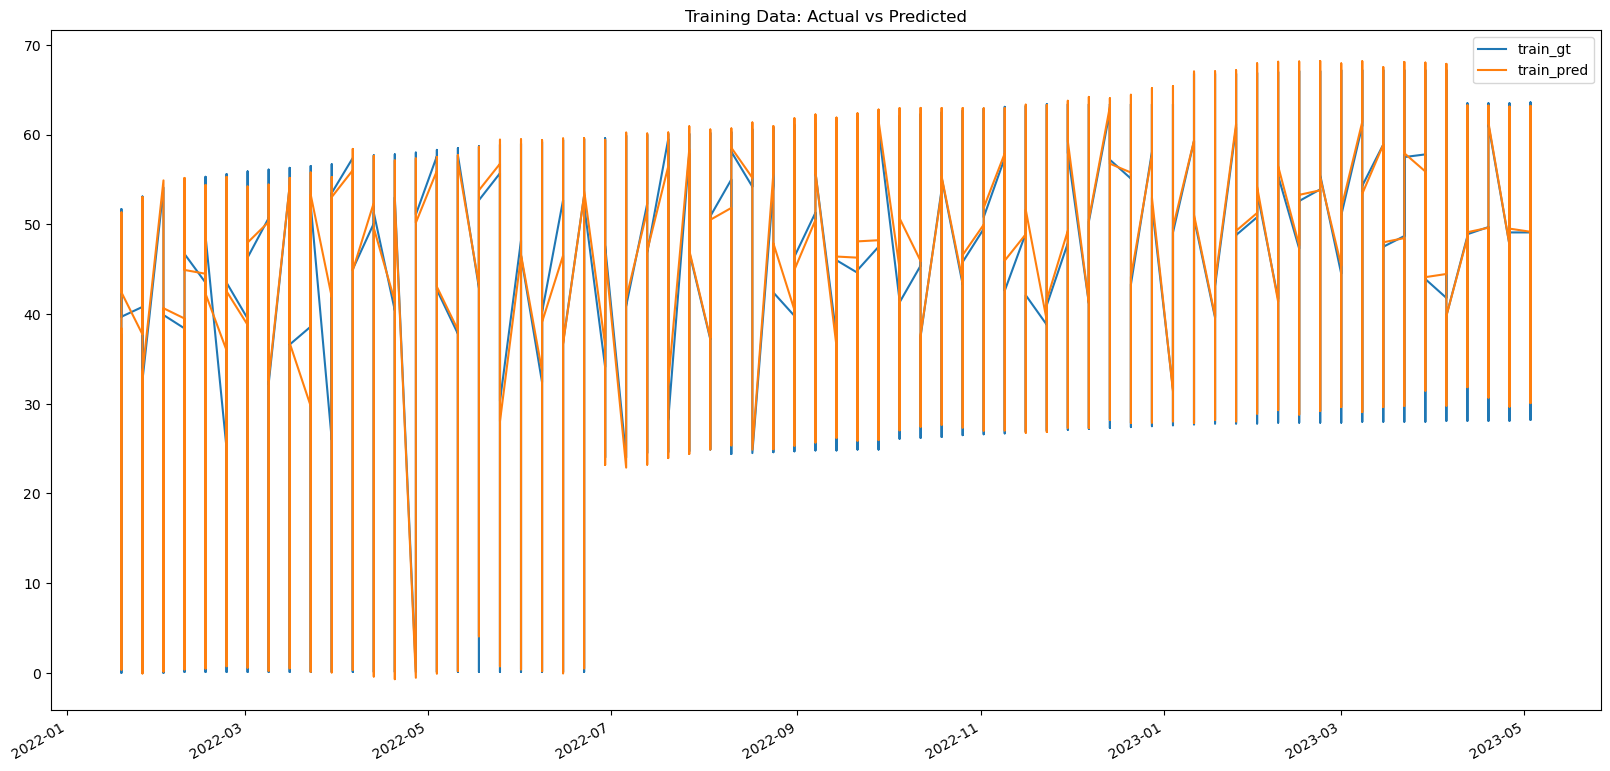

In [34]:
# Reshape the input data for the model
x_test = np.array([x[2].reshape(sequence_length, num_features) for x in test])

# Generate predictions for training data
train_pred = model.predict(np.array([x[2] for x in train]))
train_pred = pd.DataFrame(train_pred, columns=['yhat'], index=[x[0] for x in train])

# Actual values for training data
train_gt = pd.DataFrame([x[1] for x in train], columns=['y'], index=[x[0] for x in train])

# Plot training predictions and actual values
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])
plt.title('Training Data: Actual vs Predicted')
plt.show()

34/34 [==============================] - 0s 2ms/step


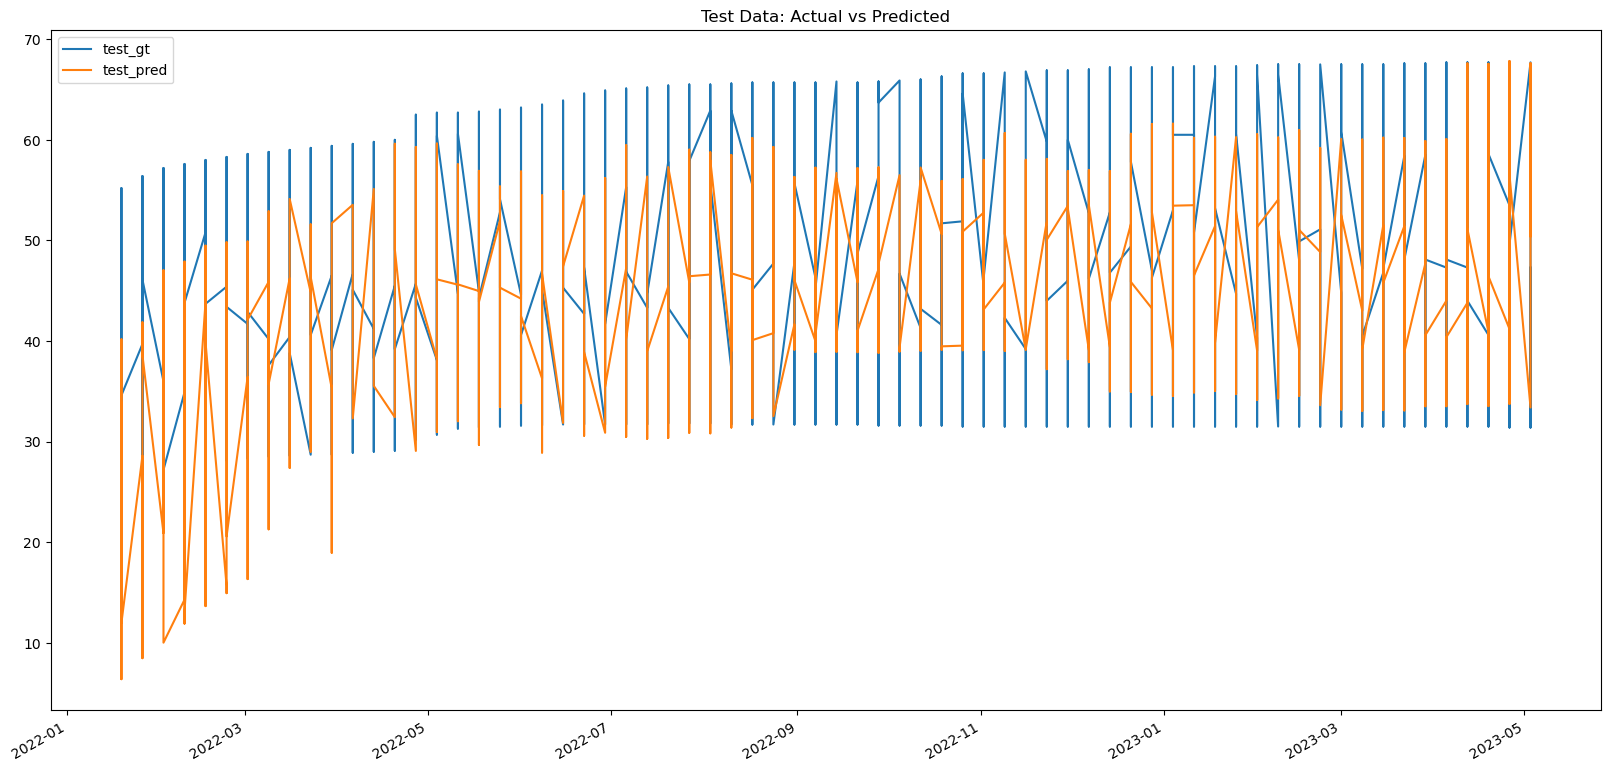

In [35]:
# Generate predictions for test data
test_pred = model.predict(x_test)
test_pred = pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test])

# Actual values for test data
test_gt = pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test])

# Plot test predictions and actual values
pd.concat([test_gt, test_pred], axis=1).plot(figsize=(20,10))
plt.legend(['test_gt', 'test_pred'])
plt.title('Test Data: Actual vs Predicted')
plt.show()

In [38]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
y_test = np.array([x[1] for x in test])
# Assuming y_train and y_test are your actual values and train_pred, test_pred are your model's predictions
y_train_pred = model.predict(x_train).flatten()
y_test_pred = model.predict(x_test).flatten()

# Training Metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Test Metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training Metrics:")
print(f"MAE: {train_mae}, RMSE: {train_rmse}, MAPE: {train_mape}, R2: {train_r2}")

print("\nTest Metrics:")
print(f"MAE: {test_mae}, RMSE: {test_rmse}, MAPE: {test_mape}, R2: {test_r2}")


34/34 [==============================] - 0s 2ms/step
Training Metrics:
MAE: 1.2129882249437227, RMSE: 2.1907842957136965, MAPE: inf, R2: 0.948788220597036

Test Metrics:
MAE: 9.487004072489562, RMSE: 12.426070368584744, MAPE: 20.031617831694952, R2: -0.838763908019017


# Model 2 (fixing issues with data leakage, shuffling, etc.)

In [2]:
# Import data
df = pd.read_csv('df_post_eda.csv')

# Convert 'Date' to datetime and sort by 'Date' and 'Location'
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date', 'Location'])

In [3]:
# Identify categorical columns except 'Location' (will be used to group)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove('Location')

# One-hot encode these categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# 'Date' and 'Location' as indices
df_encoded.set_index(['Date', 'Location'], inplace=True)

# Predictive variable
pred_var = 'Additional_Doses_Vax_Pct'

# Additional time-series columns to account for 3-month pattern
# 3 month lag
df_encoded['Additional_Doses_Vax_Pct_3_m_lag'] = df_encoded[pred_var].shift(12)

# 9 month lag
df_encoded['Additional_Doses_Vax_Pct_9_m_lag'] = df_encoded[pred_var].shift(36)

# Rolling statistics
df_encoded['rolling_mean'] = df_encoded[pred_var].shift().rolling(window=12).mean()
df_encoded['rolling_std'] = df_encoded[pred_var].shift().rolling(window=12).std()

In [4]:
def process(df, target_var):
    lag_features = [col for col in df.columns if 'lag' in col or 'rolling' in col]
    df = df[[target_var] + lag_features]
    return df.fillna(0)

# Normalize features based on training data
def normalize(train, test):
    mean = train.mean()
    std = train.std()
    
    train_normalized = (train - mean) / std
    test_normalized = (test - mean) / std
    
    return train_normalized, test_normalized

In [5]:
# Split into train and test sets (before normalization to prevent leakage)
# 1080 because it represents around 20-30% of df and is a multiple of 12
test_size = 1080 
train_df = df_encoded.iloc[:-test_size]
test_df = df_encoded.iloc[-test_size:]

# Process train and test sets separately
train_processed = process(train_df, pred_var)
test_processed = process(test_df, pred_var)

# Normalize the processed data
train_normalized, test_normalized = normalize(train_processed, test_processed)

In [6]:
# Create sequences for LSTM
def make_series(data, sequence_length):
    series = []
    for location, group in data.groupby(level='Location'):
        group = group.reset_index(level='Location', drop=True)
        for i in range(sequence_length, len(group)):
            sequence = group[i-sequence_length:i]
            target = group.iloc[i][pred_var]
            series.append((sequence.index[0], target, sequence.drop(pred_var, axis=1).values))
    return series

# 12 to capture 3 month pattern
sequence_length = 12
# Create sequences for LSTM from the normalized data
train_series = make_series(train_normalized, sequence_length)
test_series = make_series(test_normalized, sequence_length)

# Prepare data for LSTM
x_train = np.array([x[2] for x in train_series])
y_train = np.array([x[1] for x in train_series])

x_test = np.array([x[2] for x in test_series])
y_test = np.array([x[1] for x in test_series])

In [46]:
# LSTM model with Dropout
inputs = Input(shape=(sequence_length, x_train.shape[2]))
lstm_out = LSTM(32, return_sequences=False)(inputs)
lstm_out = Dropout(0.2)(lstm_out)  # Add dropout
outputs = Dense(1)(lstm_out)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mae')

# Fit the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_test, y_test),  # Add validation data
    shuffle=False  # Do not shuffle time series data
)


Epoch 1/100
102/102 [==============================] - 4s 14ms/step - loss: 0.5782 - val_loss: 0.5338
Epoch 2/100
102/102 [==============================] - 2s 20ms/step - loss: 0.5464 - val_loss: 0.5111
Epoch 3/100
102/102 [==============================] - 2s 17ms/step - loss: 0.5349 - val_loss: 0.5146
Epoch 4/100
102/102 [==============================] - 1s 13ms/step - loss: 0.5285 - val_loss: 0.5135
Epoch 5/100
102/102 [==============================] - 1s 12ms/step - loss: 0.5236 - val_loss: 0.5079
Epoch 6/100
102/102 [==============================] - 1s 12ms/step - loss: 0.5162 - val_loss: 0.5095
Epoch 7/100
102/102 [==============================] - 1s 14ms/step - loss: 0.5176 - val_loss: 0.5118
Epoch 8/100
102/102 [==============================] - 2s 17ms/step - loss: 0.5093 - val_loss: 0.5155
Epoch 9/100
102/102 [==============================] - 1s 12ms/step - loss: 0.5066 - val_loss: 0.5145
Epoch 10/100
102/102 [==============================] - 1s 12ms/step - loss: 0.501

10/10 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Training Data: Actual vs Predicted')

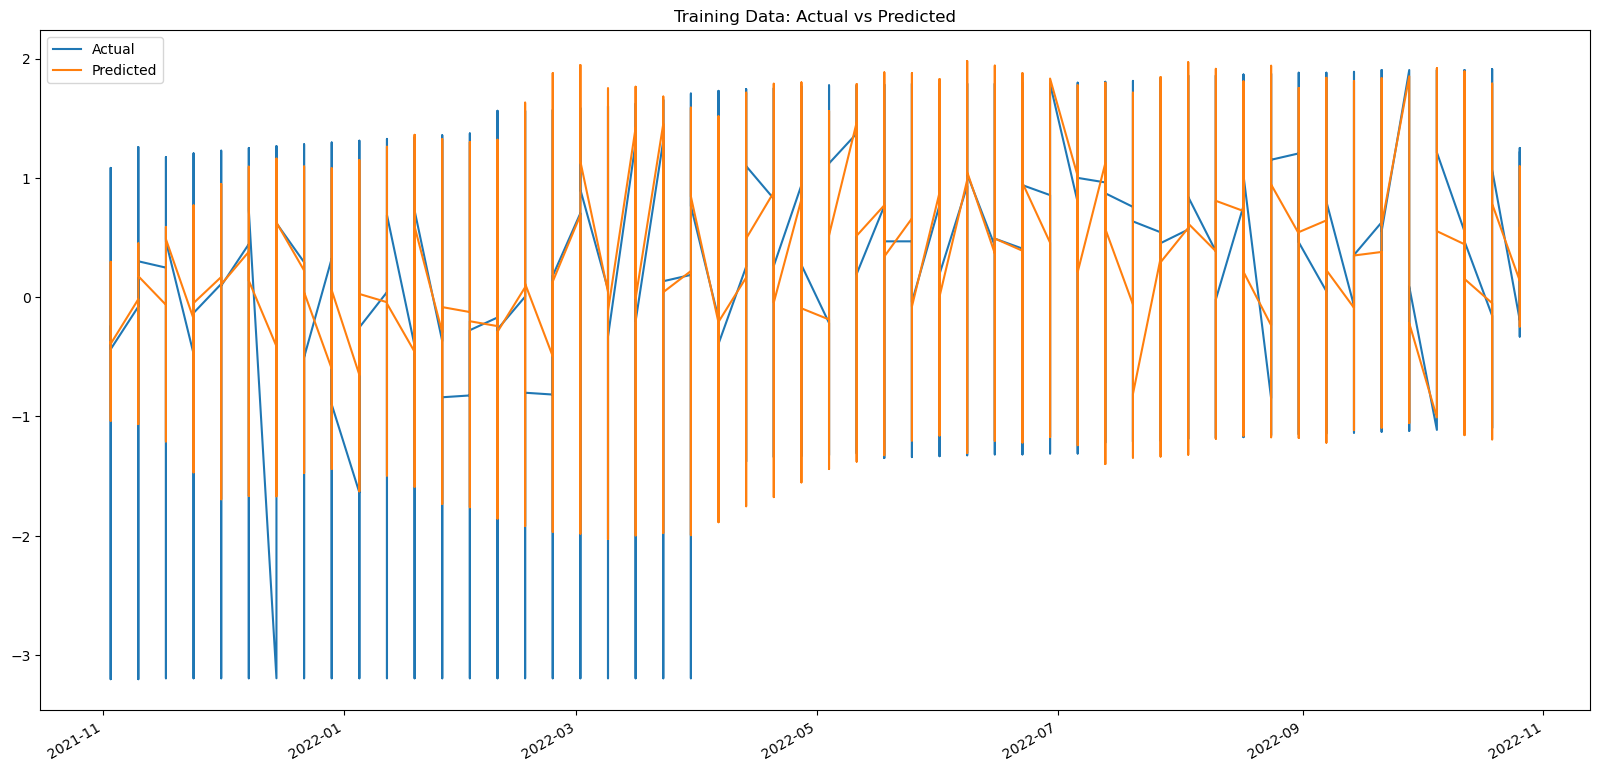

In [47]:
# Predictions
train_pred = model.predict(x_train).flatten()  # Flatten to ensure it's a 1D array
test_pred = model.predict(x_test).flatten()

# Create DataFrames for the actual and predicted values with proper indexing
# Ensure the index is constructed correctly for the training ground truth
train_indices = [x[0] for x in train_series]
train_gt = pd.DataFrame(y_train, columns=['y'], index=train_indices)
train_pred_df = pd.DataFrame(train_pred, columns=['yhat'], index=train_indices)

# Plot training predictions and actual values
pd.concat([train_gt, train_pred_df], axis=1).plot(figsize=(20,10))
plt.legend(['Actual', 'Predicted'])
plt.title('Training Data: Actual vs Predicted')


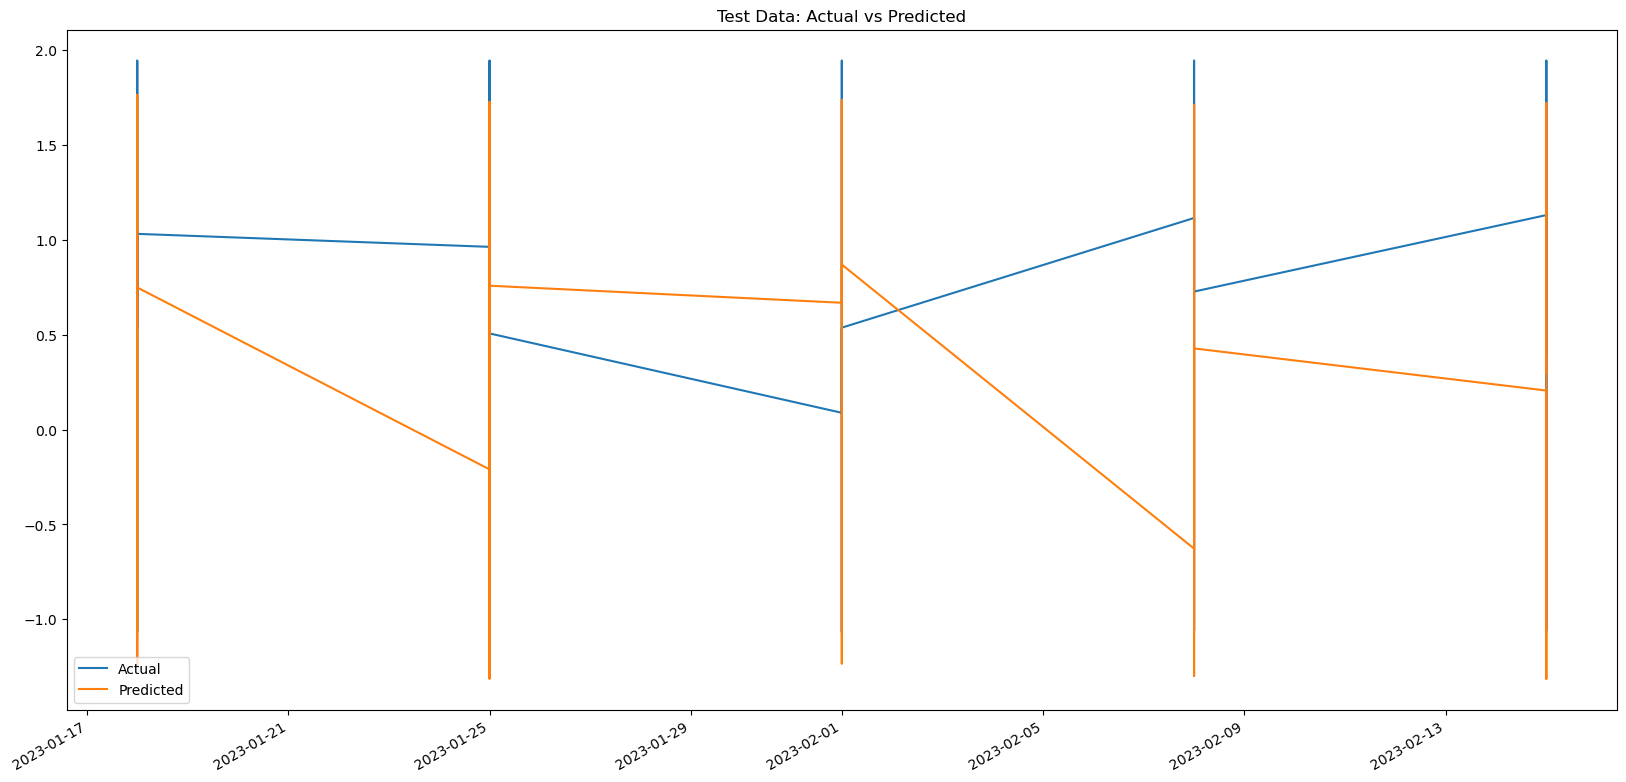

In [48]:
# Ensure the index is constructed correctly for the test ground truth
test_indices = [x[0] for x in test_series]
test_gt = pd.DataFrame(y_test, columns=['y'], index=test_indices)
test_pred_df = pd.DataFrame(test_pred, columns=['yhat'], index=test_indices)

# Plot test predictions and actual values
pd.concat([test_gt, test_pred_df], axis=1).plot(figsize=(20,10))
plt.legend(['Actual', 'Predicted'])
plt.title('Test Data: Actual vs Predicted')
plt.show()

In [49]:
# Calculate metrics
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)

test_mae = mean_absolute_error(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_r2 = r2_score(y_test, test_pred)

print("Training Metrics:")
print(f"MAE: {train_mae}")
print(f"RMSE: {train_rmse}")
print(f"R2: {train_r2}")

print("\nTest Metrics:")
print(f"MAE: {test_mae}")
print(f"RMSE: {test_rmse}")
print(f"R2: {test_r2}")

Training Metrics:
MAE: 0.32268704171759766
RMSE: 0.48598794200271234
R2: 0.5533473649826067

Test Metrics:
MAE: 0.4950548070670639
RMSE: 0.6533203848473983
R2: -0.08561650822169797


# Model 3 

Models 1 and 2 clearly are overfitting as evidenced by poor performance on the test data. To address this, the following iteration of the model I will make the model less complex by employing early stopping.

In [54]:
def build_model(sequence_length, num_features):
    inputs = Input(shape=(sequence_length, num_features))
    lstm_out = Bidirectional(LSTM(16, return_sequences=True, 
                                  kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))(inputs)
    lstm_out = BatchNormalization()(lstm_out)
    lstm_out = Dropout(0.5)(lstm_out)
    lstm_out = LSTM(8, return_sequences=False,
                    kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)
    lstm_out = Dropout(0.5)(lstm_out)
    outputs = Dense(1)(lstm_out)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mae')
    return model

# Create the model
model = build_model(sequence_length, num_features)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(x_test, y_test),
    shuffle=False,
    callbacks=[early_stopping]
)

# Predictions
train_pred = model.predict(x_train).flatten()
test_pred = model.predict(x_test).flatten()

# Calculate metrics
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)

test_mae = mean_absolute_error(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_r2 = r2_score(y_test, test_pred)


Epoch 1/100
51/51 [==============================] - 23s 139ms/step - loss: 4.1986 - val_loss: 3.2538
Epoch 2/100
51/51 [==============================] - 2s 36ms/step - loss: 3.5578 - val_loss: 2.7734
Epoch 3/100
51/51 [==============================] - 2s 37ms/step - loss: 3.0375 - val_loss: 2.3647
Epoch 4/100
51/51 [==============================] - 2s 43ms/step - loss: 2.5770 - val_loss: 2.0263
Epoch 5/100
51/51 [==============================] - 2s 41ms/step - loss: 2.1988 - val_loss: 1.7357
Epoch 6/100
51/51 [==============================] - 2s 34ms/step - loss: 1.8495 - val_loss: 1.5224
Epoch 7/100
51/51 [==============================] - 2s 30ms/step - loss: 1.6153 - val_loss: 1.3372
Epoch 8/100
51/51 [==============================] - 2s 30ms/step - loss: 1.4167 - val_loss: 1.1825
Epoch 9/100
51/51 [==============================] - 1s 27ms/step - loss: 1.2557 - val_loss: 1.0848
Epoch 10/100
51/51 [==============================] - 2s 35ms/step - loss: 1.1519 - val_loss: 1.02

In [55]:
print("Training Metrics:")
print(f"MAE: {train_mae}, RMSE: {train_rmse}, R2: {train_r2}")

print("\nTest Metrics:")
print(f"MAE: {test_mae}, RMSE: {test_rmse}, R2: {test_r2}")

Training Metrics:
MAE: 0.5320625246586381, RMSE: 0.7015863155623071, R2: 0.06914693830457419

Test Metrics:
MAE: 0.5240718509452139, RMSE: 0.6605198294399317, R2: -0.10967484304226938


# Model 4
This code introduces a learning rate scheduler that decreases the learning rate as training progresses, which can help with the convergence of the training process. It also employs early stopping to prevent overfitting and potentially speed up training by stopping when the validation loss isn't improving.

Epoch 1/100
51/51 [==============================] - 4s 36ms/step - loss: 9.7511 - val_loss: 6.1840 - lr: 0.0010
Epoch 2/100
51/51 [==============================] - 1s 24ms/step - loss: 3.8766 - val_loss: 2.0657 - lr: 0.0010
Epoch 3/100
51/51 [==============================] - 1s 25ms/step - loss: 1.2461 - val_loss: 0.8176 - lr: 0.0010
Epoch 4/100
51/51 [==============================] - 1s 25ms/step - loss: 0.7163 - val_loss: 0.6692 - lr: 0.0010
Epoch 5/100
51/51 [==============================] - 1s 28ms/step - loss: 0.6344 - val_loss: 0.6298 - lr: 0.0010
Epoch 6/100
51/51 [==============================] - 2s 33ms/step - loss: 0.6084 - val_loss: 0.6160 - lr: 0.0010
Epoch 7/100
51/51 [==============================] - 2s 36ms/step - loss: 0.5940 - val_loss: 0.6000 - lr: 0.0010
Epoch 8/100
51/51 [==============================] - 2s 34ms/step - loss: 0.5865 - val_loss: 0.5948 - lr: 0.0010
Epoch 9/100
51/51 [==============================] - 2s 31ms/step - loss: 0.5820 - val_loss: 0.5

Epoch 71/100
51/51 [==============================] - 2s 39ms/step - loss: 0.5335 - val_loss: 0.5322 - lr: 2.2429e-06
Epoch 72/100
51/51 [==============================] - 2s 39ms/step - loss: 0.5326 - val_loss: 0.5322 - lr: 2.0294e-06
Epoch 73/100
51/51 [==============================] - 2s 43ms/step - loss: 0.5306 - val_loss: 0.5322 - lr: 1.8363e-06
Epoch 74/100
51/51 [==============================] - 2s 43ms/step - loss: 0.5330 - val_loss: 0.5322 - lr: 1.6616e-06
Epoch 75/100
51/51 [==============================] - 2s 45ms/step - loss: 0.5332 - val_loss: 0.5322 - lr: 1.5034e-06
Epoch 76/100
51/51 [==============================] - 2s 43ms/step - loss: 0.5320 - val_loss: 0.5322 - lr: 1.3604e-06
Epoch 77/100
51/51 [==============================] - 2s 39ms/step - loss: 0.5314 - val_loss: 0.5322 - lr: 1.2309e-06
Epoch 78/100
51/51 [==============================] - 2s 45ms/step - loss: 0.5306 - val_loss: 0.5322 - lr: 1.1138e-06
Epoch 79/100
51/51 [==============================] - 3s

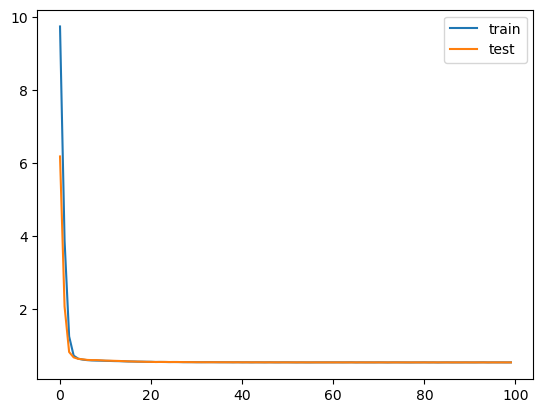

10/10 [==============================] - 0s 7ms/step
Training Metrics:
MAE: 0.5221932716159775, RMSE: 0.6913620392122943, R2: 0.09608004841719986

Test Metrics:
MAE: 0.5237665468893071, RMSE: 0.6576362538317979, R2: -0.10000716449134917


In [56]:
# Define a Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

# Build the LSTM model with added complexity and regularization
def build_model(input_shape, output_units=1, neurons=64, dropout=0.3, regularization=(0.01, 0.01)):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=input_shape,
                   kernel_regularizer=l1_l2(*regularization)))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=False, 
                   kernel_regularizer=l1_l2(*regularization)))
    model.add(Dropout(dropout))
    model.add(Dense(output_units))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')
    return model

# Callbacks
lr_schedule = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Model training
model = build_model(input_shape=(sequence_length, x_train.shape[2]))
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(x_test, y_test),
    shuffle=False,
    callbacks=[lr_schedule, early_stopping]
)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Generate predictions
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

# Calculate metrics
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)

test_mae = mean_absolute_error(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_r2 = r2_score(y_test, test_pred)

print("Training Metrics:")
print(f"MAE: {train_mae}, RMSE: {train_rmse}, R2: {train_r2}")

print("\nTest Metrics:")
print(f"MAE: {test_mae}, RMSE: {test_rmse}, R2: {test_r2}")


# Model 5

Changes:
1. Varying the dropout rates.
2. Adjusting the L1 and L2 regularization strengths.
3. Experimenting with different batch sizes.
4. Modifying the learning rate decay in the learning rate scheduler.

Used 16 neurons to prevent overfitting, a 0.3 learning rate to prevent underfitting, and since I've used 0.01 in my previous model, I want to try a smaller value like 0.0001 since I suspect overfitting is still an issue.

In [8]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1 * (epoch // 10))  # More aggressive decay every 10 epochs

# Adjusting the regularization strengths and dropout rates
def build_model(input_shape, output_units=1, neurons=16, dropout=0.3, l1_reg=0.0001, l2_reg=0.0001):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=input_shape,
                   kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=False, 
                   kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(Dropout(dropout))
    model.add(Dense(output_units))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')
    return model

Epoch 1/100
102/102 [==============================] - 5s 20ms/step - loss: 0.6003 - val_loss: 0.5788 - lr: 0.0010
Epoch 2/100
102/102 [==============================] - 1s 12ms/step - loss: 0.5683 - val_loss: 0.5748 - lr: 0.0010
Epoch 3/100
102/102 [==============================] - 1s 12ms/step - loss: 0.5616 - val_loss: 0.5552 - lr: 0.0010
Epoch 4/100
102/102 [==============================] - 1s 12ms/step - loss: 0.5563 - val_loss: 0.5592 - lr: 0.0010
Epoch 5/100
102/102 [==============================] - 1s 13ms/step - loss: 0.5534 - val_loss: 0.5664 - lr: 0.0010
Epoch 6/100
102/102 [==============================] - 2s 24ms/step - loss: 0.5465 - val_loss: 0.5565 - lr: 0.0010
Epoch 7/100
102/102 [==============================] - 2s 23ms/step - loss: 0.5402 - val_loss: 0.5579 - lr: 0.0010
Epoch 8/100
102/102 [==============================] - 2s 22ms/step - loss: 0.5389 - val_loss: 0.5724 - lr: 0.0010
Epoch 9/100
102/102 [==============================] - 2s 17ms/step - loss: 0.53

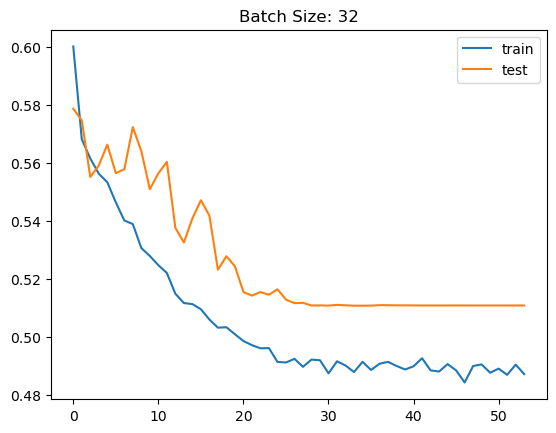

10/10 [==============================] - 0s 5ms/step
Batch Size: 32
Training Metrics:
MAE: 0.46028983631431225, RMSE: 0.6401208479923697, R2: 0.22510500420345814

Test Metrics:
MAE: 0.49483045504694684, RMSE: 0.6034130048399274, R2: 0.07390966430158585
Epoch 1/100
51/51 [==============================] - 6s 44ms/step - loss: 0.6057 - val_loss: 0.5864 - lr: 0.0010
Epoch 2/100
51/51 [==============================] - 1s 29ms/step - loss: 0.5644 - val_loss: 0.5502 - lr: 0.0010
Epoch 3/100
51/51 [==============================] - 1s 29ms/step - loss: 0.5617 - val_loss: 0.5421 - lr: 0.0010
Epoch 4/100
51/51 [==============================] - 1s 23ms/step - loss: 0.5518 - val_loss: 0.5396 - lr: 0.0010
Epoch 5/100
51/51 [==============================] - 1s 22ms/step - loss: 0.5432 - val_loss: 0.5309 - lr: 0.0010
Epoch 6/100
51/51 [==============================] - 1s 20ms/step - loss: 0.5387 - val_loss: 0.5292 - lr: 0.0010
Epoch 7/100
51/51 [==============================] - 1s 21ms/step - l

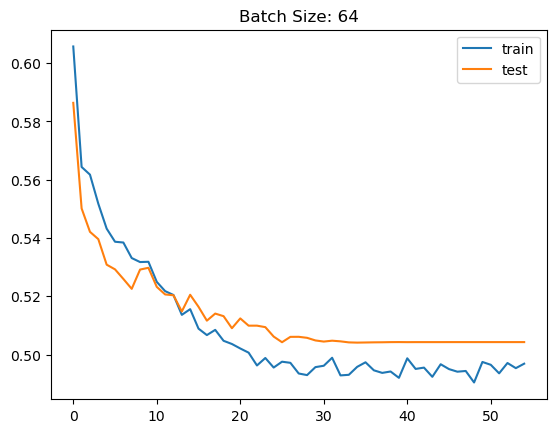

10/10 [==============================] - 1s 57ms/step
Batch Size: 64
Training Metrics:
MAE: 0.46491946925726607, RMSE: 0.6483062782463664, R2: 0.20516063594078837

Test Metrics:
MAE: 0.4885560745828174, RMSE: 0.6000665172352588, R2: 0.08415324860300566
Epoch 1/100
26/26 [==============================] - 65s 59ms/step - loss: 0.6131 - val_loss: 0.6072 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 1s 21ms/step - loss: 0.5711 - val_loss: 0.5496 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 1s 20ms/step - loss: 0.5606 - val_loss: 0.5387 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 1s 20ms/step - loss: 0.5580 - val_loss: 0.5346 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 1s 20ms/step - loss: 0.5503 - val_loss: 0.5312 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 1s 21ms/step - loss: 0.5457 - val_loss: 0.5254 - lr: 0.0010
Epoch 7/100
26/26 [==============================] - 1s 21ms/step - 

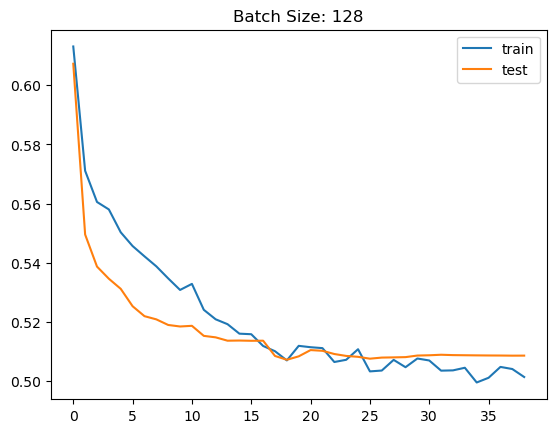

10/10 [==============================] - 0s 3ms/step
Batch Size: 128
Training Metrics:
MAE: 0.47503305550048835, RMSE: 0.6579997118517348, R2: 0.18121416767325282

Test Metrics:
MAE: 0.48923622189195054, RMSE: 0.5969731729335565, R2: 0.09357129514314955


In [58]:
# Callbacks
lr_schedule = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Assuming x_train, y_train, x_test, y_test, and sequence_length are already defined
input_shape = (sequence_length, x_train.shape[2])

# Experimenting with different batch sizes
batch_sizes = [32, 64, 128]

for batch_size in batch_sizes:
    model = build_model(input_shape)
    history = model.fit(
        x_train, y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=(x_test, y_test),
        shuffle=False,
        callbacks=[lr_schedule, early_stopping]
    )

    # Plot the training and validation loss
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.title(f'Batch Size: {batch_size}')
    plt.legend()
    plt.show()

    # Generate predictions
    train_pred = model.predict(x_train)
    test_pred = model.predict(x_test)

    # Calculate metrics
    train_mae = mean_absolute_error(y_train, train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    train_r2 = r2_score(y_train, train_pred)

    test_mae = mean_absolute_error(y_test, test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_r2 = r2_score(y_test, test_pred)

    print(f"Batch Size: {batch_size}")
    print("Training Metrics:")
    print(f"MAE: {train_mae}, RMSE: {train_rmse}, R2: {train_r2}")

    print("\nTest Metrics:")
    print(f"MAE: {test_mae}, RMSE: {test_rmse}, R2: {test_r2}")

# Model 6
Running a grid search to further optimize model.

In [9]:
# Callbacks
lr_schedule = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Define a set of hyperparameters to iterate over
neurons_options = [16, 32]
dropout_options = [0.2, 0.3]
l1_reg_options = [0.0001, 0.00001]
l2_reg_options = [0.0001, 0.00001]
batch_sizes = [32, 64, 128]

best_val_loss = float('inf')
best_config = {}

input_shape = (sequence_length, x_train.shape[2])

# Loop over all possible combinations of hyperparameters
for neurons in neurons_options:
    for dropout in dropout_options:
        for l1_reg in l1_reg_options:
            for l2_reg in l2_reg_options:
                for batch_size in batch_sizes:
                    print(f"Training with neurons: {neurons}, dropout: {dropout}, l1_reg: {l1_reg}, l2_reg: {l2_reg}, batch_size: {batch_size}")
                    
                    # Define your model-building function with updated parameters
                    model = build_model(input_shape, output_units=1, neurons=neurons, dropout=dropout, l1_reg=l1_reg, l2_reg=l2_reg)
                    
                    # Include a ModelCheckpoint callback to save the best model
                    checkpoint_filepath = f'./best_model_{neurons}_{dropout}_{l1_reg}_{l2_reg}_{batch_size}.h5'
                    model_checkpoint_callback = ModelCheckpoint(
                        filepath=checkpoint_filepath,
                        save_weights_only=True,
                        monitor='val_loss',
                        mode='min',
                        save_best_only=True)
                    
                    # Fit the model
                    history = model.fit(
                        x_train, y_train,
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
                        shuffle=False,
                        callbacks=[lr_schedule, early_stopping, model_checkpoint_callback]
                    )
                    
                    # Check if the validation loss for this model is the best
                    min_val_loss = min(history.history['val_loss'])
                    if min_val_loss < best_val_loss:
                        best_val_loss = min_val_loss
                        best_config = {'neurons': neurons, 'dropout': dropout, 'l1_reg': l1_reg, 'l2_reg': l2_reg, 'batch_size': batch_size, 'filepath': checkpoint_filepath}
                        
                    print(f"Best Validation Loss: {best_val_loss}")
                    print(f"Best Configuration: {best_config}")
                    

# Fit the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    shuffle=False,
    callbacks=[lr_schedule, early_stopping, model_checkpoint_callback]
)

# Load the best weights and compile the model before making predictions
model.load_weights(checkpoint_filepath)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Make predictions
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

# Calculate RMSE and other metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f"Batch Size: {batch_size}")
print("Training Metrics:")
print(f"MAE: {mean_absolute_error(y_train, train_pred)}, RMSE: {train_rmse}")

print("\nTest Metrics:")
print(f"MAE: {mean_absolute_error(y_test, test_pred)}, RMSE: {test_rmse}")

# Check if the validation loss for this model is the best
min_val_loss = min(history.history['val_loss'])
if min_val_loss < best_val_loss:
    best_val_loss = min_val_loss
    best_config = {
        'neurons': neurons,
        'dropout': dropout,
        'l1_reg': l1_reg,
        'l2_reg': l2_reg,
        'batch_size': batch_size,
        'filepath': checkpoint_filepath,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    }

print(f"Best Validation Loss: {best_val_loss}")
print(f"Best Configuration: {best_config}")

Training with neurons: 16, dropout: 0.2, l1_reg: 0.0001, l2_reg: 0.0001, batch_size: 32


2023-11-12 17:36:47.620632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
102/102 [==============================] - 7s 28ms/step - loss: 0.5902 - val_loss: 0.5776 - lr: 0.0010
Epoch 2/100
102/102 [==============================] - 1s 15ms/step - loss: 0.5676 - val_loss: 0.5700 - lr: 0.0010
Epoch 3/100
102/102 [==============================] - 2s 15ms/step - loss: 0.5577 - val_loss: 0.5627 - lr: 0.0010
Epoch 4/100
102/102 [==============================] - 2s 15ms/step - loss: 0.5566 - val_loss: 0.5543 - lr: 0.0010
Epoch 5/100
102/102 [==============================] - 2s 15ms/step - loss: 0.5480 - val_loss: 0.5506 - lr: 0.0010
Epoch 6/100
102/102 [==============================] - 2s 15ms/step - loss: 0.5491 - val_loss: 0.5506 - lr: 0.0010
Epoch 7/100
102/102 [==============================] - 2s 15ms/step - loss: 0.5433 - val_loss: 0.5534 - lr: 0.0010
Epoch 8/100
102/102 [==============================] - 1s 15ms/step - loss: 0.5416 - val_loss: 0.5509 - lr: 0.0010
Epoch 9/100
102/102 [==============================] - 2s 15ms/step - loss: 0.53

Epoch 30/100
26/26 [==============================] - 1s 22ms/step - loss: 0.4966 - val_loss: 0.5126 - lr: 4.9787e-05
Epoch 31/100
26/26 [==============================] - 1s 21ms/step - loss: 0.4968 - val_loss: 0.5125 - lr: 3.6883e-05
Epoch 32/100
26/26 [==============================] - 1s 21ms/step - loss: 0.4946 - val_loss: 0.5129 - lr: 2.7324e-05
Epoch 33/100
26/26 [==============================] - 1s 20ms/step - loss: 0.4969 - val_loss: 0.5127 - lr: 2.0242e-05
Epoch 34/100
26/26 [==============================] - 1s 20ms/step - loss: 0.4940 - val_loss: 0.5127 - lr: 1.4996e-05
Epoch 35/100
26/26 [==============================] - 1s 24ms/step - loss: 0.4934 - val_loss: 0.5127 - lr: 1.1109e-05
Epoch 36/100
26/26 [==============================] - 1s 25ms/step - loss: 0.4974 - val_loss: 0.5127 - lr: 8.2297e-06
Epoch 37/100
26/26 [==============================] - 1s 25ms/step - loss: 0.4935 - val_loss: 0.5127 - lr: 6.0967e-06
Epoch 38/100
26/26 [==============================] - 1s

51/51 [==============================] - 5s 34ms/step - loss: 0.5972 - val_loss: 0.5913 - lr: 0.0010
Epoch 2/100
51/51 [==============================] - 1s 19ms/step - loss: 0.5572 - val_loss: 0.5393 - lr: 0.0010
Epoch 3/100
51/51 [==============================] - 1s 19ms/step - loss: 0.5502 - val_loss: 0.5363 - lr: 0.0010
Epoch 4/100
51/51 [==============================] - 1s 18ms/step - loss: 0.5463 - val_loss: 0.5329 - lr: 0.0010
Epoch 5/100
51/51 [==============================] - 1s 23ms/step - loss: 0.5391 - val_loss: 0.5302 - lr: 0.0010
Epoch 6/100
51/51 [==============================] - 1s 22ms/step - loss: 0.5355 - val_loss: 0.5347 - lr: 0.0010
Epoch 7/100
51/51 [==============================] - 1s 24ms/step - loss: 0.5268 - val_loss: 0.5255 - lr: 0.0010
Epoch 8/100
51/51 [==============================] - 1s 23ms/step - loss: 0.5265 - val_loss: 0.5261 - lr: 0.0010
Epoch 9/100
51/51 [==============================] - 1s 20ms/step - loss: 0.5205 - val_loss: 0.5187 - lr: 0.

Epoch 17/100
26/26 [==============================] - 1s 28ms/step - loss: 0.5084 - val_loss: 0.4998 - lr: 4.9659e-04
Epoch 18/100
26/26 [==============================] - 1s 26ms/step - loss: 0.5103 - val_loss: 0.4971 - lr: 4.4933e-04
Epoch 19/100
26/26 [==============================] - 1s 31ms/step - loss: 0.5068 - val_loss: 0.4971 - lr: 4.0657e-04
Epoch 20/100
26/26 [==============================] - 1s 31ms/step - loss: 0.5069 - val_loss: 0.4958 - lr: 3.6788e-04
Epoch 21/100
26/26 [==============================] - 1s 27ms/step - loss: 0.5053 - val_loss: 0.4965 - lr: 3.0119e-04
Epoch 22/100
26/26 [==============================] - 1s 26ms/step - loss: 0.5030 - val_loss: 0.4944 - lr: 2.4660e-04
Epoch 23/100
26/26 [==============================] - 1s 25ms/step - loss: 0.4997 - val_loss: 0.4939 - lr: 2.0190e-04
Epoch 24/100
26/26 [==============================] - 1s 24ms/step - loss: 0.5049 - val_loss: 0.4929 - lr: 1.6530e-04
Epoch 25/100
26/26 [==============================] - 1s

Epoch 36/100
102/102 [==============================] - 2s 18ms/step - loss: 0.4702 - val_loss: 0.4857 - lr: 8.2297e-06
Epoch 37/100
102/102 [==============================] - 3s 26ms/step - loss: 0.4697 - val_loss: 0.4856 - lr: 6.0967e-06
Epoch 38/100
102/102 [==============================] - 2s 17ms/step - loss: 0.4667 - val_loss: 0.4856 - lr: 4.5166e-06
Epoch 39/100
102/102 [==============================] - 2s 16ms/step - loss: 0.4747 - val_loss: 0.4857 - lr: 3.3460e-06
Epoch 40/100
102/102 [==============================] - 2s 18ms/step - loss: 0.4732 - val_loss: 0.4856 - lr: 2.4788e-06
Epoch 41/100
102/102 [==============================] - 2s 21ms/step - loss: 0.4729 - val_loss: 0.4856 - lr: 1.6616e-06
Epoch 42/100
102/102 [==============================] - 2s 20ms/step - loss: 0.4674 - val_loss: 0.4856 - lr: 1.1138e-06
Epoch 43/100
102/102 [==============================] - 2s 16ms/step - loss: 0.4709 - val_loss: 0.4856 - lr: 7.4659e-07
Epoch 44/100
102/102 [==================

Epoch 5/100
26/26 [==============================] - 1s 23ms/step - loss: 0.5332 - val_loss: 0.5230 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 1s 22ms/step - loss: 0.5267 - val_loss: 0.5157 - lr: 0.0010
Epoch 7/100
26/26 [==============================] - 1s 22ms/step - loss: 0.5243 - val_loss: 0.5114 - lr: 0.0010
Epoch 8/100
26/26 [==============================] - 1s 23ms/step - loss: 0.5210 - val_loss: 0.5105 - lr: 0.0010
Epoch 9/100
26/26 [==============================] - 1s 25ms/step - loss: 0.5170 - val_loss: 0.5106 - lr: 0.0010
Epoch 10/100
26/26 [==============================] - 1s 22ms/step - loss: 0.5177 - val_loss: 0.5026 - lr: 0.0010
Epoch 11/100
26/26 [==============================] - 1s 22ms/step - loss: 0.5118 - val_loss: 0.5011 - lr: 9.0484e-04
Epoch 12/100
26/26 [==============================] - 1s 25ms/step - loss: 0.5085 - val_loss: 0.5001 - lr: 8.1873e-04
Epoch 13/100
26/26 [==============================] - 1s 23ms/step - loss: 0.5055 - v

51/51 [==============================] - 1s 21ms/step - loss: 0.5153 - val_loss: 0.5118 - lr: 0.0010
Epoch 10/100
51/51 [==============================] - 1s 21ms/step - loss: 0.5124 - val_loss: 0.5115 - lr: 0.0010
Epoch 11/100
51/51 [==============================] - 1s 24ms/step - loss: 0.5055 - val_loss: 0.5140 - lr: 9.0484e-04
Epoch 12/100
51/51 [==============================] - 1s 26ms/step - loss: 0.5028 - val_loss: 0.5151 - lr: 8.1873e-04
Epoch 13/100
51/51 [==============================] - 1s 25ms/step - loss: 0.4997 - val_loss: 0.5122 - lr: 7.4082e-04
Epoch 14/100
51/51 [==============================] - 1s 24ms/step - loss: 0.4951 - val_loss: 0.5109 - lr: 6.7032e-04
Epoch 15/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4914 - val_loss: 0.5146 - lr: 6.0653e-04
Epoch 16/100
51/51 [==============================] - 1s 22ms/step - loss: 0.4879 - val_loss: 0.5014 - lr: 5.4881e-04
Epoch 17/100
51/51 [==============================] - 1s 23ms/step - loss: 0.

102/102 [==============================] - 2s 20ms/step - loss: 0.4828 - val_loss: 0.4854 - lr: 3.6883e-05
Epoch 32/100
102/102 [==============================] - 2s 19ms/step - loss: 0.4812 - val_loss: 0.4850 - lr: 2.7324e-05
Epoch 33/100
102/102 [==============================] - 2s 21ms/step - loss: 0.4817 - val_loss: 0.4846 - lr: 2.0242e-05
Epoch 34/100
102/102 [==============================] - 2s 17ms/step - loss: 0.4835 - val_loss: 0.4846 - lr: 1.4996e-05
Epoch 35/100
102/102 [==============================] - 2s 15ms/step - loss: 0.4825 - val_loss: 0.4846 - lr: 1.1109e-05
Epoch 36/100
102/102 [==============================] - 2s 15ms/step - loss: 0.4855 - val_loss: 0.4844 - lr: 8.2297e-06
Epoch 37/100
102/102 [==============================] - 2s 16ms/step - loss: 0.4822 - val_loss: 0.4844 - lr: 6.0967e-06
Epoch 38/100
102/102 [==============================] - 2s 16ms/step - loss: 0.4803 - val_loss: 0.4844 - lr: 4.5166e-06
Epoch 39/100
102/102 [==============================]

51/51 [==============================] - 1s 21ms/step - loss: 0.5016 - val_loss: 0.5195 - lr: 4.5166e-06
Epoch 39/100
51/51 [==============================] - 1s 20ms/step - loss: 0.4988 - val_loss: 0.5195 - lr: 3.3460e-06
Epoch 40/100
51/51 [==============================] - 1s 19ms/step - loss: 0.4971 - val_loss: 0.5194 - lr: 2.4788e-06
Epoch 41/100
51/51 [==============================] - 1s 20ms/step - loss: 0.5055 - val_loss: 0.5194 - lr: 1.6616e-06
Epoch 42/100
51/51 [==============================] - 1s 20ms/step - loss: 0.5002 - val_loss: 0.5194 - lr: 1.1138e-06
Epoch 43/100
51/51 [==============================] - 1s 20ms/step - loss: 0.5002 - val_loss: 0.5194 - lr: 7.4659e-07
Epoch 44/100
51/51 [==============================] - 1s 19ms/step - loss: 0.5038 - val_loss: 0.5194 - lr: 5.0045e-07
Epoch 45/100
51/51 [==============================] - 1s 19ms/step - loss: 0.4998 - val_loss: 0.5194 - lr: 3.3546e-07
Epoch 46/100
51/51 [==============================] - 1s 21ms/step - 

Epoch 51/100
102/102 [==============================] - 5s 45ms/step - loss: 0.4865 - val_loss: 0.5171 - lr: 2.7536e-08
Epoch 52/100
102/102 [==============================] - 4s 44ms/step - loss: 0.4875 - val_loss: 0.5171 - lr: 1.6702e-08
Epoch 53/100
102/102 [==============================] - 4s 39ms/step - loss: 0.4910 - val_loss: 0.5171 - lr: 1.0130e-08
Best Validation Loss: 0.48370224237442017
Best Configuration: {'neurons': 16, 'dropout': 0.2, 'l1_reg': 1e-05, 'l2_reg': 1e-05, 'batch_size': 32, 'filepath': './best_model_16_0.2_1e-05_1e-05_32.h5'}
Training with neurons: 16, dropout: 0.3, l1_reg: 0.0001, l2_reg: 1e-05, batch_size: 64
Epoch 1/100
51/51 [==============================] - 7s 35ms/step - loss: 0.5984 - val_loss: 0.5711 - lr: 0.0010
Epoch 2/100
51/51 [==============================] - 1s 20ms/step - loss: 0.5692 - val_loss: 0.5528 - lr: 0.0010
Epoch 3/100
51/51 [==============================] - 1s 20ms/step - loss: 0.5612 - val_loss: 0.5425 - lr: 0.0010
Epoch 4/100
51/

102/102 [==============================] - 2s 18ms/step - loss: 0.4907 - val_loss: 0.4994 - lr: 5.4881e-04
Epoch 17/100
102/102 [==============================] - 5s 48ms/step - loss: 0.4884 - val_loss: 0.4926 - lr: 4.9659e-04
Epoch 18/100
102/102 [==============================] - 5s 48ms/step - loss: 0.4924 - val_loss: 0.4883 - lr: 4.4933e-04
Epoch 19/100
102/102 [==============================] - 4s 36ms/step - loss: 0.4903 - val_loss: 0.4884 - lr: 4.0657e-04
Epoch 20/100
102/102 [==============================] - 5s 47ms/step - loss: 0.4857 - val_loss: 0.4872 - lr: 3.6788e-04
Epoch 21/100
102/102 [==============================] - 3s 33ms/step - loss: 0.4818 - val_loss: 0.4854 - lr: 3.0119e-04
Epoch 22/100
102/102 [==============================] - 4s 35ms/step - loss: 0.4827 - val_loss: 0.4865 - lr: 2.4660e-04
Epoch 23/100
102/102 [==============================] - 5s 52ms/step - loss: 0.4817 - val_loss: 0.4879 - lr: 2.0190e-04
Epoch 24/100
102/102 [==============================]

Epoch 33/100
51/51 [==============================] - 2s 31ms/step - loss: 0.4821 - val_loss: 0.4947 - lr: 2.0242e-05
Epoch 34/100
51/51 [==============================] - 2s 38ms/step - loss: 0.4891 - val_loss: 0.4947 - lr: 1.4996e-05
Epoch 35/100
51/51 [==============================] - 1s 24ms/step - loss: 0.4844 - val_loss: 0.4947 - lr: 1.1109e-05
Epoch 36/100
51/51 [==============================] - 1s 26ms/step - loss: 0.4884 - val_loss: 0.4947 - lr: 8.2297e-06
Epoch 37/100
51/51 [==============================] - 1s 26ms/step - loss: 0.4862 - val_loss: 0.4947 - lr: 6.0967e-06
Epoch 38/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4811 - val_loss: 0.4948 - lr: 4.5166e-06
Epoch 39/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4863 - val_loss: 0.4948 - lr: 3.3460e-06
Epoch 40/100
51/51 [==============================] - 1s 22ms/step - loss: 0.4810 - val_loss: 0.4948 - lr: 2.4788e-06
Epoch 41/100
51/51 [==============================] - 1s

Epoch 44/100
102/102 [==============================] - 2s 21ms/step - loss: 0.4712 - val_loss: 0.4853 - lr: 5.0045e-07
Epoch 45/100
102/102 [==============================] - 2s 22ms/step - loss: 0.4747 - val_loss: 0.4853 - lr: 3.3546e-07
Epoch 46/100
102/102 [==============================] - 2s 20ms/step - loss: 0.4707 - val_loss: 0.4853 - lr: 2.2487e-07
Epoch 47/100
102/102 [==============================] - 2s 17ms/step - loss: 0.4709 - val_loss: 0.4853 - lr: 1.5073e-07
Epoch 48/100
102/102 [==============================] - 2s 17ms/step - loss: 0.4730 - val_loss: 0.4853 - lr: 1.0104e-07
Epoch 49/100
102/102 [==============================] - 2s 16ms/step - loss: 0.4762 - val_loss: 0.4853 - lr: 6.7729e-08
Epoch 50/100
102/102 [==============================] - 2s 16ms/step - loss: 0.4751 - val_loss: 0.4853 - lr: 4.5400e-08
Epoch 51/100
102/102 [==============================] - 2s 17ms/step - loss: 0.4724 - val_loss: 0.4853 - lr: 2.7536e-08
Epoch 52/100
102/102 [==================

Epoch 39/100
51/51 [==============================] - 1s 25ms/step - loss: 0.4870 - val_loss: 0.5041 - lr: 3.3460e-06
Epoch 40/100
51/51 [==============================] - 1s 27ms/step - loss: 0.4877 - val_loss: 0.5041 - lr: 2.4788e-06
Epoch 41/100
51/51 [==============================] - 1s 25ms/step - loss: 0.4885 - val_loss: 0.5041 - lr: 1.6616e-06
Epoch 42/100
51/51 [==============================] - 1s 25ms/step - loss: 0.4887 - val_loss: 0.5040 - lr: 1.1138e-06
Epoch 43/100
51/51 [==============================] - 1s 20ms/step - loss: 0.4880 - val_loss: 0.5040 - lr: 7.4659e-07
Epoch 44/100
51/51 [==============================] - 1s 20ms/step - loss: 0.4867 - val_loss: 0.5040 - lr: 5.0045e-07
Epoch 45/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4870 - val_loss: 0.5040 - lr: 3.3546e-07
Epoch 46/100
51/51 [==============================] - 1s 19ms/step - loss: 0.4871 - val_loss: 0.5040 - lr: 2.2487e-07
Epoch 47/100
51/51 [==============================] - 1s

51/51 [==============================] - 1s 21ms/step - loss: 0.5521 - val_loss: 0.5451 - lr: 0.0010
Epoch 8/100
51/51 [==============================] - 1s 21ms/step - loss: 0.5487 - val_loss: 0.5411 - lr: 0.0010
Epoch 9/100
51/51 [==============================] - 1s 22ms/step - loss: 0.5423 - val_loss: 0.5609 - lr: 0.0010
Epoch 10/100
51/51 [==============================] - 1s 21ms/step - loss: 0.5327 - val_loss: 0.5476 - lr: 0.0010
Epoch 11/100
51/51 [==============================] - 1s 21ms/step - loss: 0.5267 - val_loss: 0.5559 - lr: 9.0484e-04
Epoch 12/100
51/51 [==============================] - 1s 23ms/step - loss: 0.5216 - val_loss: 0.5249 - lr: 8.1873e-04
Epoch 13/100
51/51 [==============================] - 1s 22ms/step - loss: 0.5119 - val_loss: 0.5194 - lr: 7.4082e-04
Epoch 14/100
51/51 [==============================] - 1s 23ms/step - loss: 0.5098 - val_loss: 0.5132 - lr: 6.7032e-04
Epoch 15/100
51/51 [==============================] - 1s 29ms/step - loss: 0.5059 - val

Epoch 28/100
26/26 [==============================] - 1s 24ms/step - loss: 0.4937 - val_loss: 0.5009 - lr: 7.4274e-05
Epoch 29/100
26/26 [==============================] - 1s 24ms/step - loss: 0.4929 - val_loss: 0.5011 - lr: 6.0810e-05
Epoch 30/100
26/26 [==============================] - 1s 25ms/step - loss: 0.4918 - val_loss: 0.5008 - lr: 4.9787e-05
Epoch 31/100
26/26 [==============================] - 1s 25ms/step - loss: 0.4948 - val_loss: 0.5007 - lr: 3.6883e-05
Epoch 32/100
26/26 [==============================] - 1s 29ms/step - loss: 0.4914 - val_loss: 0.5007 - lr: 2.7324e-05
Epoch 33/100
26/26 [==============================] - 1s 28ms/step - loss: 0.4917 - val_loss: 0.5005 - lr: 2.0242e-05
Epoch 34/100
26/26 [==============================] - 1s 32ms/step - loss: 0.4918 - val_loss: 0.5005 - lr: 1.4996e-05
Epoch 35/100
26/26 [==============================] - 1s 33ms/step - loss: 0.4932 - val_loss: 0.5005 - lr: 1.1109e-05
Epoch 36/100
26/26 [==============================] - 1s

Epoch 39/100
102/102 [==============================] - 2s 23ms/step - loss: 0.4795 - val_loss: 0.5005 - lr: 3.3460e-06
Epoch 40/100
102/102 [==============================] - 3s 25ms/step - loss: 0.4794 - val_loss: 0.5005 - lr: 2.4788e-06
Epoch 41/100
102/102 [==============================] - 2s 20ms/step - loss: 0.4798 - val_loss: 0.5005 - lr: 1.6616e-06
Epoch 42/100
102/102 [==============================] - 2s 21ms/step - loss: 0.4794 - val_loss: 0.5004 - lr: 1.1138e-06
Epoch 43/100
102/102 [==============================] - 2s 21ms/step - loss: 0.4792 - val_loss: 0.5005 - lr: 7.4659e-07
Epoch 44/100
102/102 [==============================] - 2s 18ms/step - loss: 0.4788 - val_loss: 0.5004 - lr: 5.0045e-07
Epoch 45/100
102/102 [==============================] - 2s 18ms/step - loss: 0.4805 - val_loss: 0.5004 - lr: 3.3546e-07
Epoch 46/100
102/102 [==============================] - 2s 19ms/step - loss: 0.4799 - val_loss: 0.5004 - lr: 2.2487e-07
Epoch 47/100
102/102 [==================

Epoch 34/100
51/51 [==============================] - 1s 22ms/step - loss: 0.4911 - val_loss: 0.4990 - lr: 1.4996e-05
Epoch 35/100
51/51 [==============================] - 1s 22ms/step - loss: 0.4944 - val_loss: 0.4991 - lr: 1.1109e-05
Epoch 36/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4941 - val_loss: 0.4993 - lr: 8.2297e-06
Epoch 37/100
51/51 [==============================] - 1s 29ms/step - loss: 0.4920 - val_loss: 0.4993 - lr: 6.0967e-06
Epoch 38/100
51/51 [==============================] - 1s 27ms/step - loss: 0.4922 - val_loss: 0.4993 - lr: 4.5166e-06
Epoch 39/100
51/51 [==============================] - 1s 28ms/step - loss: 0.4931 - val_loss: 0.4992 - lr: 3.3460e-06
Epoch 40/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4925 - val_loss: 0.4992 - lr: 2.4788e-06
Epoch 41/100
51/51 [==============================] - 1s 27ms/step - loss: 0.4924 - val_loss: 0.4992 - lr: 1.6616e-06
Epoch 42/100
51/51 [==============================] - 1s

Epoch 21/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4756 - val_loss: 0.4930 - lr: 3.0119e-04
Epoch 22/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4728 - val_loss: 0.4949 - lr: 2.4660e-04
Epoch 23/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4740 - val_loss: 0.4959 - lr: 2.0190e-04
Epoch 24/100
51/51 [==============================] - 1s 22ms/step - loss: 0.4747 - val_loss: 0.4930 - lr: 1.6530e-04
Epoch 25/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4678 - val_loss: 0.4951 - lr: 1.3534e-04
Epoch 26/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4688 - val_loss: 0.4917 - lr: 1.1080e-04
Epoch 27/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4717 - val_loss: 0.4927 - lr: 9.0718e-05
Epoch 28/100
51/51 [==============================] - 1s 22ms/step - loss: 0.4699 - val_loss: 0.4919 - lr: 7.4274e-05
Epoch 29/100
51/51 [==============================] - 1s

Epoch 32/100
102/102 [==============================] - 2s 20ms/step - loss: 0.4588 - val_loss: 0.4742 - lr: 2.7324e-05
Epoch 33/100
102/102 [==============================] - 2s 19ms/step - loss: 0.4570 - val_loss: 0.4744 - lr: 2.0242e-05
Epoch 34/100
102/102 [==============================] - 2s 18ms/step - loss: 0.4609 - val_loss: 0.4745 - lr: 1.4996e-05
Epoch 35/100
102/102 [==============================] - 2s 19ms/step - loss: 0.4585 - val_loss: 0.4743 - lr: 1.1109e-05
Epoch 36/100
102/102 [==============================] - 2s 20ms/step - loss: 0.4600 - val_loss: 0.4743 - lr: 8.2297e-06
Epoch 37/100
102/102 [==============================] - 2s 19ms/step - loss: 0.4605 - val_loss: 0.4742 - lr: 6.0967e-06
Epoch 38/100
102/102 [==============================] - 2s 19ms/step - loss: 0.4603 - val_loss: 0.4743 - lr: 4.5166e-06
Epoch 39/100
102/102 [==============================] - 2s 20ms/step - loss: 0.4592 - val_loss: 0.4743 - lr: 3.3460e-06
Epoch 40/100
102/102 [==================

Epoch 34/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4696 - val_loss: 0.4796 - lr: 1.4996e-05
Epoch 35/100
51/51 [==============================] - 1s 28ms/step - loss: 0.4672 - val_loss: 0.4795 - lr: 1.1109e-05
Epoch 36/100
51/51 [==============================] - 1s 28ms/step - loss: 0.4700 - val_loss: 0.4795 - lr: 8.2297e-06
Epoch 37/100
51/51 [==============================] - 1s 27ms/step - loss: 0.4677 - val_loss: 0.4796 - lr: 6.0967e-06
Epoch 38/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4681 - val_loss: 0.4795 - lr: 4.5166e-06
Epoch 39/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4685 - val_loss: 0.4795 - lr: 3.3460e-06
Epoch 40/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4679 - val_loss: 0.4795 - lr: 2.4788e-06
Epoch 41/100
51/51 [==============================] - 1s 24ms/step - loss: 0.4667 - val_loss: 0.4795 - lr: 1.6616e-06
Epoch 42/100
51/51 [==============================] - 1s

Epoch 49/100
102/102 [==============================] - 2s 20ms/step - loss: 0.4790 - val_loss: 0.4991 - lr: 6.7729e-08
Epoch 50/100
102/102 [==============================] - 2s 22ms/step - loss: 0.4798 - val_loss: 0.4991 - lr: 4.5400e-08
Epoch 51/100
102/102 [==============================] - 2s 23ms/step - loss: 0.4770 - val_loss: 0.4991 - lr: 2.7536e-08
Epoch 52/100
102/102 [==============================] - 2s 19ms/step - loss: 0.4793 - val_loss: 0.4991 - lr: 1.6702e-08
Epoch 53/100
102/102 [==============================] - 2s 19ms/step - loss: 0.4792 - val_loss: 0.4991 - lr: 1.0130e-08
Epoch 54/100
102/102 [==============================] - 2s 19ms/step - loss: 0.4801 - val_loss: 0.4991 - lr: 6.1442e-09
Epoch 55/100
102/102 [==============================] - 2s 18ms/step - loss: 0.4787 - val_loss: 0.4991 - lr: 3.7267e-09
Epoch 56/100
102/102 [==============================] - 2s 18ms/step - loss: 0.4807 - val_loss: 0.4991 - lr: 2.2603e-09
Epoch 57/100
102/102 [==================

Epoch 7/100
26/26 [==============================] - 1s 25ms/step - loss: 0.5426 - val_loss: 0.5381 - lr: 0.0010
Epoch 8/100
26/26 [==============================] - 1s 28ms/step - loss: 0.5371 - val_loss: 0.5353 - lr: 0.0010
Epoch 9/100
26/26 [==============================] - 1s 27ms/step - loss: 0.5374 - val_loss: 0.5364 - lr: 0.0010
Epoch 10/100
26/26 [==============================] - 1s 30ms/step - loss: 0.5300 - val_loss: 0.5352 - lr: 0.0010
Epoch 11/100
26/26 [==============================] - 1s 29ms/step - loss: 0.5235 - val_loss: 0.5324 - lr: 9.0484e-04
Epoch 12/100
26/26 [==============================] - 1s 29ms/step - loss: 0.5207 - val_loss: 0.5273 - lr: 8.1873e-04
Epoch 13/100
26/26 [==============================] - 1s 35ms/step - loss: 0.5183 - val_loss: 0.5262 - lr: 7.4082e-04
Epoch 14/100
26/26 [==============================] - 1s 37ms/step - loss: 0.5195 - val_loss: 0.5211 - lr: 6.7032e-04
Epoch 15/100
26/26 [==============================] - 1s 35ms/step - loss: 

Epoch 19/100
51/51 [==============================] - 1s 23ms/step - loss: 0.5001 - val_loss: 0.5136 - lr: 4.0657e-04
Epoch 20/100
51/51 [==============================] - 1s 24ms/step - loss: 0.4980 - val_loss: 0.5113 - lr: 3.6788e-04
Epoch 21/100
51/51 [==============================] - 2s 32ms/step - loss: 0.4947 - val_loss: 0.5145 - lr: 3.0119e-04
Epoch 22/100
51/51 [==============================] - 2s 41ms/step - loss: 0.4959 - val_loss: 0.5117 - lr: 2.4660e-04
Epoch 23/100
51/51 [==============================] - 2s 49ms/step - loss: 0.4956 - val_loss: 0.5089 - lr: 2.0190e-04
Epoch 24/100
51/51 [==============================] - 2s 36ms/step - loss: 0.4938 - val_loss: 0.5099 - lr: 1.6530e-04
Epoch 25/100
51/51 [==============================] - 2s 32ms/step - loss: 0.4903 - val_loss: 0.5074 - lr: 1.3534e-04
Epoch 26/100
51/51 [==============================] - 2s 38ms/step - loss: 0.4913 - val_loss: 0.5062 - lr: 1.1080e-04
Epoch 27/100
51/51 [==============================] - 1s

Epoch 48/100
102/102 [==============================] - 2s 20ms/step - loss: 0.4711 - val_loss: 0.4858 - lr: 1.0104e-07
Epoch 49/100
102/102 [==============================] - 2s 19ms/step - loss: 0.4697 - val_loss: 0.4858 - lr: 6.7729e-08
Epoch 50/100
102/102 [==============================] - 2s 18ms/step - loss: 0.4695 - val_loss: 0.4858 - lr: 4.5400e-08
Epoch 51/100
102/102 [==============================] - 2s 19ms/step - loss: 0.4732 - val_loss: 0.4858 - lr: 2.7536e-08
Epoch 52/100
102/102 [==============================] - 2s 18ms/step - loss: 0.4750 - val_loss: 0.4858 - lr: 1.6702e-08
Epoch 53/100
102/102 [==============================] - 2s 18ms/step - loss: 0.4714 - val_loss: 0.4858 - lr: 1.0130e-08
Epoch 54/100
102/102 [==============================] - 2s 18ms/step - loss: 0.4714 - val_loss: 0.4858 - lr: 6.1442e-09
Epoch 55/100
102/102 [==============================] - 2s 18ms/step - loss: 0.4701 - val_loss: 0.4858 - lr: 3.7267e-09
Epoch 56/100
102/102 [==================

Epoch 3/100
26/26 [==============================] - 1s 33ms/step - loss: 0.5450 - val_loss: 0.5260 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 1s 32ms/step - loss: 0.5424 - val_loss: 0.5164 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 1s 33ms/step - loss: 0.5335 - val_loss: 0.5196 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 1s 31ms/step - loss: 0.5317 - val_loss: 0.5126 - lr: 0.0010
Epoch 7/100
26/26 [==============================] - 1s 31ms/step - loss: 0.5261 - val_loss: 0.5138 - lr: 0.0010
Epoch 8/100
26/26 [==============================] - 1s 27ms/step - loss: 0.5246 - val_loss: 0.5185 - lr: 0.0010
Epoch 9/100
26/26 [==============================] - 1s 23ms/step - loss: 0.5194 - val_loss: 0.5128 - lr: 0.0010
Epoch 10/100
26/26 [==============================] - 1s 25ms/step - loss: 0.5177 - val_loss: 0.5102 - lr: 0.0010
Epoch 11/100
26/26 [==============================] - 1s 27ms/step - loss: 0.5112 - val_loss: 0

Epoch 27/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4717 - val_loss: 0.4754 - lr: 9.0718e-05
Epoch 28/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4718 - val_loss: 0.4747 - lr: 7.4274e-05
Epoch 29/100
51/51 [==============================] - 1s 26ms/step - loss: 0.4697 - val_loss: 0.4743 - lr: 6.0810e-05
Epoch 30/100
51/51 [==============================] - 1s 28ms/step - loss: 0.4695 - val_loss: 0.4743 - lr: 4.9787e-05
Epoch 31/100
51/51 [==============================] - 1s 25ms/step - loss: 0.4701 - val_loss: 0.4745 - lr: 3.6883e-05
Epoch 32/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4687 - val_loss: 0.4746 - lr: 2.7324e-05
Epoch 33/100
51/51 [==============================] - 1s 20ms/step - loss: 0.4690 - val_loss: 0.4749 - lr: 2.0242e-05
Epoch 34/100
51/51 [==============================] - 1s 20ms/step - loss: 0.4693 - val_loss: 0.4748 - lr: 1.4996e-05
Epoch 35/100
51/51 [==============================] - 1s

# Scaled data
## Initial model

In [3]:
# Import data
df = pd.read_csv('df_post_eda.csv')

# Convert 'Date' to datetime and sort by 'Date' and 'Location'
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date', 'Location'])

In [4]:
# Identify categorical columns except 'Location' (will be used to group)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove('Location')

# One-hot encode these categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# 'Date' and 'Location' as indices
df_encoded.set_index(['Date', 'Location'], inplace=True)

# Predictive variable
pred_var = 'Additional_Doses_Vax_Pct'

# Additional time-series columns to account for 3-month pattern
# 3 month lag
df_encoded['Additional_Doses_Vax_Pct_3_m_lag'] = df_encoded[pred_var].shift(12)

# 9 month lag
df_encoded['Additional_Doses_Vax_Pct_9_m_lag'] = df_encoded[pred_var].shift(36)

# Rolling statistics
df_encoded['rolling_mean'] = df_encoded[pred_var].shift().rolling(window=12).mean()
df_encoded['rolling_std'] = df_encoded[pred_var].shift().rolling(window=12).std()

# Initialize an instance of MinMaxScaler that will scale features to the range [0, 1]
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

# Apply the scaler to the data, transforming all features to a scaled version
# and create a new DataFrame with these scaled values
df = pd.DataFrame(min_max_scaler.fit_transform(df_encoded), columns=df_encoded.columns, index=df_encoded.index).reset_index()

In [5]:
def process(df, target_var):
    lag_features = [col for col in df.columns if 'lag' in col or 'rolling' in col]
    df = df[[target_var] + lag_features]
    return df.fillna(0)

# Normalize features based on training data
def normalize(train, test):
    mean = train.mean()
    std = train.std()
    
    train_normalized = (train - mean) / std
    test_normalized = (test - mean) / std
    
    return train_normalized, test_normalized

In [6]:
# Split into train and test sets (before normalization to prevent leakage)
# 1080 because it represents around 20-30% of df and is a multiple of 12
test_size = 1080 
train_df = df_encoded.iloc[:-test_size]
test_df = df_encoded.iloc[-test_size:]

# Process train and test sets separately
train_processed = process(train_df, pred_var)
test_processed = process(test_df, pred_var)

# Normalize the processed data
train_normalized, test_normalized = normalize(train_processed, test_processed)

In [7]:
# Create sequences for LSTM
def make_series(data, sequence_length):
    series = []
    for location, group in data.groupby(level='Location'):
        group = group.reset_index(level='Location', drop=True)
        for i in range(sequence_length, len(group)):
            sequence = group[i-sequence_length:i]
            target = group.iloc[i][pred_var]
            series.append((sequence.index[0], target, sequence.drop(pred_var, axis=1).values))
    return series

# 12 to capture 3 month pattern
sequence_length = 12
# Create sequences for LSTM from the normalized data
train_series = make_series(train_normalized, sequence_length)
test_series = make_series(test_normalized, sequence_length)

# Prepare data for LSTM
x_train = np.array([x[2] for x in train_series])
y_train = np.array([x[1] for x in train_series])

x_test = np.array([x[2] for x in test_series])
y_test = np.array([x[1] for x in test_series])

In [8]:
# LSTM model with Dropout
inputs = Input(shape=(sequence_length, x_train.shape[2]))
lstm_out = LSTM(32, return_sequences=False)(inputs)
lstm_out = Dropout(0.2)(lstm_out)  # Add dropout
outputs = Dense(1)(lstm_out)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mae')

# Fit the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_test, y_test),  # Add validation data
    shuffle=False  # Do not shuffle time series data
)


2023-11-15 01:35:24.148369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
102/102 [==============================] - 4s 16ms/step - loss: 0.5772 - val_loss: 0.5383
Epoch 2/100
102/102 [==============================] - 1s 10ms/step - loss: 0.5502 - val_loss: 0.5281
Epoch 3/100
102/102 [==============================] - 1s 11ms/step - loss: 0.5397 - val_loss: 0.5270
Epoch 4/100
102/102 [==============================] - 1s 10ms/step - loss: 0.5362 - val_loss: 0.5194
Epoch 5/100
102/102 [==============================] - 1s 11ms/step - loss: 0.5266 - val_loss: 0.5144
Epoch 6/100
102/102 [==============================] - 1s 11ms/step - loss: 0.5231 - val_loss: 0.5121
Epoch 7/100
102/102 [==============================] - 1s 10ms/step - loss: 0.5166 - val_loss: 0.5090
Epoch 8/100
102/102 [==============================] - 1s 11ms/step - loss: 0.5089 - val_loss: 0.5015
Epoch 9/100
102/102 [==============================] - 1s 12ms/step - loss: 0.5036 - val_loss: 0.4966
Epoch 10/100
102/102 [==============================] - 2s 17ms/step - loss: 0.500

10/10 [==============================] - 0s 4ms/step


Text(0.5, 1.0, 'Training Data: Actual vs Predicted')

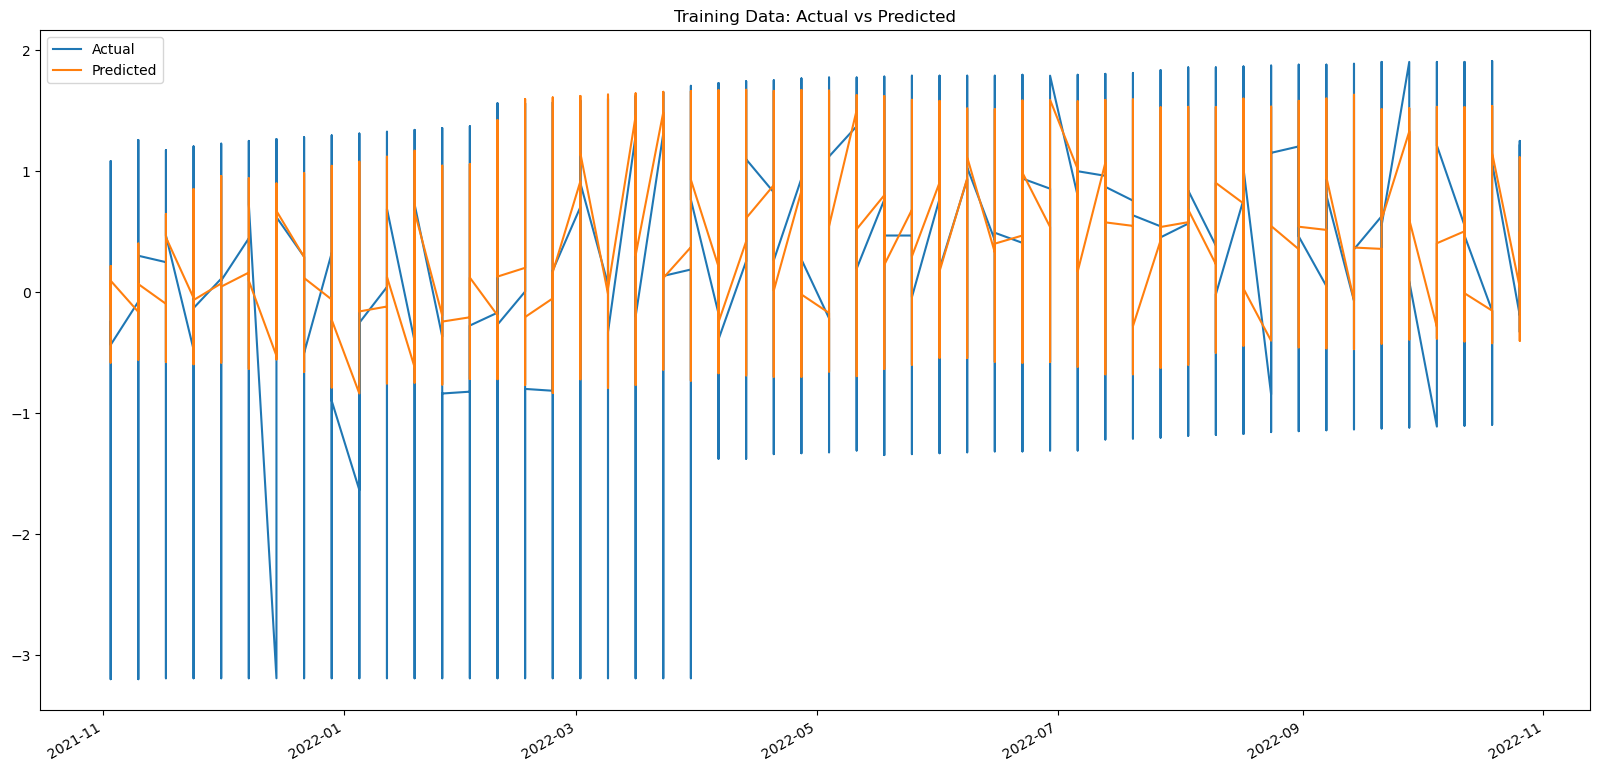

In [9]:
# Predictions
train_pred = model.predict(x_train).flatten()  # Flatten to ensure it's a 1D array
test_pred = model.predict(x_test).flatten()

# Create DataFrames for the actual and predicted values with proper indexing
# Ensure the index is constructed correctly for the training ground truth
train_indices = [x[0] for x in train_series]
train_gt = pd.DataFrame(y_train, columns=['y'], index=train_indices)
train_pred_df = pd.DataFrame(train_pred, columns=['yhat'], index=train_indices)

# Plot training predictions and actual values
pd.concat([train_gt, train_pred_df], axis=1).plot(figsize=(20,10))
plt.legend(['Actual', 'Predicted'])
plt.title('Training Data: Actual vs Predicted')


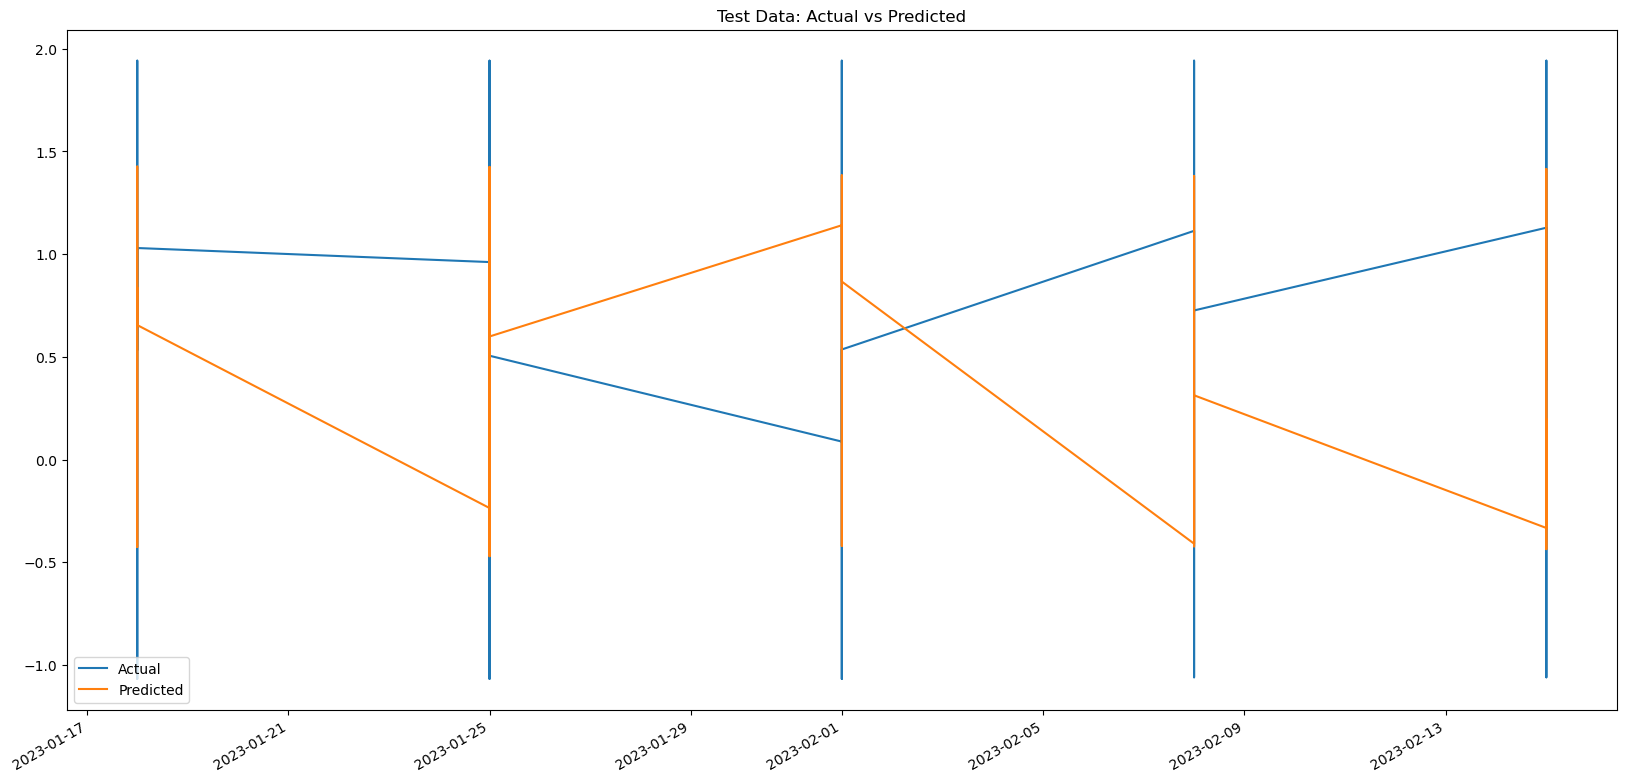

In [10]:
# Ensure the index is constructed correctly for the test ground truth
test_indices = [x[0] for x in test_series]
test_gt = pd.DataFrame(y_test, columns=['y'], index=test_indices)
test_pred_df = pd.DataFrame(test_pred, columns=['yhat'], index=test_indices)

# Plot test predictions and actual values
pd.concat([test_gt, test_pred_df], axis=1).plot(figsize=(20,10))
plt.legend(['Actual', 'Predicted'])
plt.title('Test Data: Actual vs Predicted')
plt.show()

In [11]:
# Calculate metrics
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)

test_mae = mean_absolute_error(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_r2 = r2_score(y_test, test_pred)

print("Training Metrics:")
print(f"MAE: {train_mae}")
print(f"RMSE: {train_rmse}")
print(f"R2: {train_r2}")

print("\nTest Metrics:")
print(f"MAE: {test_mae}")
print(f"RMSE: {test_rmse}")
print(f"R2: {test_r2}")

Training Metrics:
MAE: 0.3425666605969359
RMSE: 0.5124171478433944
R2: 0.503446300244422

Test Metrics:
MAE: 0.5082166213362523
RMSE: 0.664193593282009
R2: -0.1220530344076054


## Early stopping

In [14]:
num_features = train_normalized.shape[1] - 1  # excluding the target variable

def build_model(sequence_length, num_features):
    inputs = Input(shape=(sequence_length, num_features))
    lstm_out = Bidirectional(LSTM(16, return_sequences=True, 
                                  kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))(inputs)
    lstm_out = BatchNormalization()(lstm_out)
    lstm_out = Dropout(0.5)(lstm_out)
    lstm_out = LSTM(8, return_sequences=False,
                    kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)
    lstm_out = Dropout(0.5)(lstm_out)
    outputs = Dense(1)(lstm_out)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mae')
    return model

# Create the model
model = build_model(sequence_length, num_features)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(x_test, y_test),
    shuffle=False,
    callbacks=[early_stopping]
)

# Predictions
train_pred = model.predict(x_train).flatten()
test_pred = model.predict(x_test).flatten()

# Calculate metrics
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)

test_mae = mean_absolute_error(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_r2 = r2_score(y_test, test_pred)


Epoch 1/100
51/51 [==============================] - 7s 49ms/step - loss: 4.0232 - val_loss: 3.3239
Epoch 2/100
51/51 [==============================] - 1s 22ms/step - loss: 3.3337 - val_loss: 2.7985
Epoch 3/100
51/51 [==============================] - 2s 30ms/step - loss: 2.8101 - val_loss: 2.3456
Epoch 4/100
51/51 [==============================] - 1s 26ms/step - loss: 2.3390 - val_loss: 1.9697
Epoch 5/100
51/51 [==============================] - 2s 32ms/step - loss: 1.9628 - val_loss: 1.6501
Epoch 6/100
51/51 [==============================] - 2s 33ms/step - loss: 1.6656 - val_loss: 1.4024
Epoch 7/100
51/51 [==============================] - 2s 32ms/step - loss: 1.4025 - val_loss: 1.2054
Epoch 8/100
51/51 [==============================] - 2s 33ms/step - loss: 1.2291 - val_loss: 1.0801
Epoch 9/100
51/51 [==============================] - 1s 28ms/step - loss: 1.0928 - val_loss: 0.9923
Epoch 10/100
51/51 [==============================] - 1s 26ms/step - loss: 1.0058 - val_loss: 0.9191

In [15]:
print("Training Metrics:")
print(f"MAE: {train_mae}, RMSE: {train_rmse}, R2: {train_r2}")

print("\nTest Metrics:")
print(f"MAE: {test_mae}, RMSE: {test_rmse}, R2: {test_r2}")

Training Metrics:
MAE: 0.5310289496059272, RMSE: 0.7019937934199418, R2: 0.06806535460973484

Test Metrics:
MAE: 0.5199155154514065, RMSE: 0.6563455568857468, R2: -0.0956935864856534


## Grid search

In [16]:
# Import data
df = pd.read_csv('df_post_eda.csv')

# Convert 'Date' to datetime and sort by 'Date' and 'Location'
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date', 'Location'])

In [83]:
# Identify categorical columns except 'Location' (will be used to group)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove('Location')

# One-hot encode these categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# 'Date' and 'Location' as indices
df_encoded.set_index(['Date', 'Location'], inplace=True)

# Predictive variable
pred_var = 'Additional_Doses_Vax_Pct'

# Additional time-series columns to account for 3-month pattern
# 3 month lag
df_encoded['Additional_Doses_Vax_Pct_3_m_lag'] = df_encoded[pred_var].shift(12)

# 9 month lag
df_encoded['Additional_Doses_Vax_Pct_9_m_lag'] = df_encoded[pred_var].shift(36)

# Rolling statistics
df_encoded['rolling_mean'] = df_encoded[pred_var].shift().rolling(window=12).mean()
df_encoded['rolling_std'] = df_encoded[pred_var].shift().rolling(window=12).std()

# Initialize an instance of MinMaxScaler that will scale features to the range [0, 1]
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

# Apply the scaler to the data, transforming all features to a scaled version
# and create a new DataFrame with these scaled values
df = pd.DataFrame(min_max_scaler.fit_transform(df_encoded), columns=df_encoded.columns, index=df_encoded.index).reset_index()

In [18]:
def process(df, target_var):
    lag_features = [col for col in df.columns if 'lag' in col or 'rolling' in col]
    df = df[[target_var] + lag_features]
    return df.fillna(0)

# Normalize features based on training data
def normalize(train, test):
    mean = train.mean()
    std = train.std()
    
    train_normalized = (train - mean) / std
    test_normalized = (test - mean) / std
    
    return train_normalized, test_normalized

In [19]:
# Split into train and test sets (before normalization to prevent leakage)
# 1080 because it represents around 20-30% of df and is a multiple of 12
test_size = 1080 
train_df = df_encoded.iloc[:-test_size]
test_df = df_encoded.iloc[-test_size:]

# Process train and test sets separately
train_processed = process(train_df, pred_var)
test_processed = process(test_df, pred_var)

# Normalize the processed data
train_normalized, test_normalized = normalize(train_processed, test_processed)

In [20]:
# Create sequences for LSTM
def make_series(data, sequence_length):
    series = []
    for location, group in data.groupby(level='Location'):
        group = group.reset_index(level='Location', drop=True)
        for i in range(sequence_length, len(group)):
            sequence = group[i-sequence_length:i]
            target = group.iloc[i][pred_var]
            series.append((sequence.index[0], target, sequence.drop(pred_var, axis=1).values))
    return series

# 12 to capture 3 month pattern
sequence_length = 12
# Create sequences for LSTM from the normalized data
train_series = make_series(train_normalized, sequence_length)
test_series = make_series(test_normalized, sequence_length)

# Prepare data for LSTM
x_train = np.array([x[2] for x in train_series])
y_train = np.array([x[1] for x in train_series])

x_test = np.array([x[2] for x in test_series])
y_test = np.array([x[1] for x in test_series])

In [21]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1 * (epoch // 10))  # More aggressive decay every 10 epochs

# Adjusting the regularization strengths and dropout rates
def build_model(input_shape, output_units=1, neurons=16, dropout=0.3, l1_reg=0.0001, l2_reg=0.0001):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=input_shape,
                   kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=False, 
                   kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(Dropout(dropout))
    model.add(Dense(output_units))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')
    return model

In [22]:
# Callbacks
lr_schedule = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Define a set of hyperparameters to iterate over
neurons_options = [16, 32]
dropout_options = [0.2, 0.3]
l1_reg_options = [0.0001, 0.00001]
l2_reg_options = [0.0001, 0.00001]
batch_sizes = [32, 64, 128]

best_val_loss = float('inf')
best_config = {}

input_shape = (sequence_length, x_train.shape[2])

# Loop over all possible combinations of hyperparameters
for neurons in neurons_options:
    for dropout in dropout_options:
        for l1_reg in l1_reg_options:
            for l2_reg in l2_reg_options:
                for batch_size in batch_sizes:
                    print(f"Training with neurons: {neurons}, dropout: {dropout}, l1_reg: {l1_reg}, l2_reg: {l2_reg}, batch_size: {batch_size}")
                    
                    # Define your model-building function with updated parameters
                    model = build_model(input_shape, output_units=1, neurons=neurons, dropout=dropout, l1_reg=l1_reg, l2_reg=l2_reg)
                    
                    # Include a ModelCheckpoint callback to save the best model
                    checkpoint_filepath = f'./best_model_{neurons}_{dropout}_{l1_reg}_{l2_reg}_{batch_size}.h5'
                    model_checkpoint_callback = ModelCheckpoint(
                        filepath=checkpoint_filepath,
                        save_weights_only=True,
                        monitor='val_loss',
                        mode='min',
                        save_best_only=True)
                    
                    # Fit the model
                    history = model.fit(
                        x_train, y_train,
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
                        shuffle=False,
                        callbacks=[lr_schedule, early_stopping, model_checkpoint_callback]
                    )
                    
                    # Check if the validation loss for this model is the best
                    min_val_loss = min(history.history['val_loss'])
                    if min_val_loss < best_val_loss:
                        best_val_loss = min_val_loss
                        best_config = {'neurons': neurons, 'dropout': dropout, 'l1_reg': l1_reg, 'l2_reg': l2_reg, 'batch_size': batch_size, 'filepath': checkpoint_filepath}
                        
                    print(f"Best Validation Loss: {best_val_loss}")
                    print(f"Best Configuration: {best_config}")
                    

# Fit the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    shuffle=False,
    callbacks=[lr_schedule, early_stopping, model_checkpoint_callback]
)

# Load the best weights and compile the model before making predictions
model.load_weights(checkpoint_filepath)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Make predictions
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

# Calculate RMSE and other metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f"Batch Size: {batch_size}")
print("Training Metrics:")
print(f"MAE: {mean_absolute_error(y_train, train_pred)}, RMSE: {train_rmse}")

print("\nTest Metrics:")
print(f"MAE: {mean_absolute_error(y_test, test_pred)}, RMSE: {test_rmse}")

# Check if the validation loss for this model is the best
min_val_loss = min(history.history['val_loss'])
if min_val_loss < best_val_loss:
    best_val_loss = min_val_loss
    best_config = {
        'neurons': neurons,
        'dropout': dropout,
        'l1_reg': l1_reg,
        'l2_reg': l2_reg,
        'batch_size': batch_size,
        'filepath': checkpoint_filepath,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    }

print(f"Best Validation Loss: {best_val_loss}")
print(f"Best Configuration: {best_config}")

Training with neurons: 16, dropout: 0.2, l1_reg: 0.0001, l2_reg: 0.0001, batch_size: 32
Epoch 1/100
102/102 [==============================] - 5s 20ms/step - loss: 0.5871 - val_loss: 0.5544 - lr: 0.0010
Epoch 2/100
102/102 [==============================] - 2s 17ms/step - loss: 0.5615 - val_loss: 0.5543 - lr: 0.0010
Epoch 3/100
102/102 [==============================] - 2s 19ms/step - loss: 0.5593 - val_loss: 0.5459 - lr: 0.0010
Epoch 4/100
102/102 [==============================] - 2s 21ms/step - loss: 0.5510 - val_loss: 0.5441 - lr: 0.0010
Epoch 5/100
102/102 [==============================] - 2s 24ms/step - loss: 0.5470 - val_loss: 0.5431 - lr: 0.0010
Epoch 6/100
102/102 [==============================] - 2s 21ms/step - loss: 0.5435 - val_loss: 0.5395 - lr: 0.0010
Epoch 7/100
102/102 [==============================] - 2s 18ms/step - loss: 0.5413 - val_loss: 0.5417 - lr: 0.0010
Epoch 8/100
102/102 [==============================] - 2s 18ms/step - loss: 0.5376 - val_loss: 0.5378 - lr:

26/26 [==============================] - 1s 28ms/step - loss: 0.4980 - val_loss: 0.5015 - lr: 7.4274e-05
Epoch 29/100
26/26 [==============================] - 1s 31ms/step - loss: 0.4987 - val_loss: 0.5010 - lr: 6.0810e-05
Epoch 30/100
26/26 [==============================] - 1s 37ms/step - loss: 0.4987 - val_loss: 0.5016 - lr: 4.9787e-05
Epoch 31/100
26/26 [==============================] - 1s 33ms/step - loss: 0.4976 - val_loss: 0.5018 - lr: 3.6883e-05
Epoch 32/100
26/26 [==============================] - 1s 29ms/step - loss: 0.4962 - val_loss: 0.5020 - lr: 2.7324e-05
Epoch 33/100
26/26 [==============================] - 1s 29ms/step - loss: 0.4965 - val_loss: 0.5024 - lr: 2.0242e-05
Epoch 34/100
26/26 [==============================] - 1s 39ms/step - loss: 0.4975 - val_loss: 0.5024 - lr: 1.4996e-05
Epoch 35/100
26/26 [==============================] - 1s 33ms/step - loss: 0.4984 - val_loss: 0.5025 - lr: 1.1109e-05
Epoch 36/100
26/26 [==============================] - 1s 32ms/step - 

Epoch 46/100
102/102 [==============================] - 2s 18ms/step - loss: 0.4841 - val_loss: 0.5145 - lr: 2.2487e-07
Epoch 47/100
102/102 [==============================] - 2s 19ms/step - loss: 0.4811 - val_loss: 0.5145 - lr: 1.5073e-07
Epoch 48/100
102/102 [==============================] - 2s 17ms/step - loss: 0.4828 - val_loss: 0.5145 - lr: 1.0104e-07
Epoch 49/100
102/102 [==============================] - 2s 17ms/step - loss: 0.4800 - val_loss: 0.5145 - lr: 6.7729e-08
Epoch 50/100
102/102 [==============================] - 2s 22ms/step - loss: 0.4792 - val_loss: 0.5145 - lr: 4.5400e-08
Epoch 51/100
102/102 [==============================] - 2s 23ms/step - loss: 0.4800 - val_loss: 0.5145 - lr: 2.7536e-08
Epoch 52/100
102/102 [==============================] - 2s 18ms/step - loss: 0.4794 - val_loss: 0.5145 - lr: 1.6702e-08
Epoch 53/100
102/102 [==============================] - 2s 17ms/step - loss: 0.4791 - val_loss: 0.5145 - lr: 1.0130e-08
Epoch 54/100
102/102 [==================

26/26 [==============================] - 1s 25ms/step - loss: 0.5279 - val_loss: 0.5262 - lr: 0.0010
Epoch 9/100
26/26 [==============================] - 1s 28ms/step - loss: 0.5247 - val_loss: 0.5295 - lr: 0.0010
Epoch 10/100
26/26 [==============================] - 1s 25ms/step - loss: 0.5193 - val_loss: 0.5367 - lr: 0.0010
Epoch 11/100
26/26 [==============================] - 1s 22ms/step - loss: 0.5177 - val_loss: 0.5366 - lr: 9.0484e-04
Epoch 12/100
26/26 [==============================] - 1s 27ms/step - loss: 0.5128 - val_loss: 0.5396 - lr: 8.1873e-04
Epoch 13/100
26/26 [==============================] - 1s 23ms/step - loss: 0.5088 - val_loss: 0.5292 - lr: 7.4082e-04
Epoch 14/100
26/26 [==============================] - 1s 24ms/step - loss: 0.5080 - val_loss: 0.5387 - lr: 6.7032e-04
Epoch 15/100
26/26 [==============================] - 1s 26ms/step - loss: 0.5049 - val_loss: 0.5374 - lr: 6.0653e-04
Epoch 16/100
26/26 [==============================] - 1s 23ms/step - loss: 0.5028 

102/102 [==============================] - 2s 19ms/step - loss: 0.4736 - val_loss: 0.4878 - lr: 2.0242e-05
Epoch 34/100
102/102 [==============================] - 2s 16ms/step - loss: 0.4724 - val_loss: 0.4878 - lr: 1.4996e-05
Epoch 35/100
102/102 [==============================] - 2s 19ms/step - loss: 0.4737 - val_loss: 0.4877 - lr: 1.1109e-05
Epoch 36/100
102/102 [==============================] - 2s 21ms/step - loss: 0.4750 - val_loss: 0.4877 - lr: 8.2297e-06
Epoch 37/100
102/102 [==============================] - 2s 18ms/step - loss: 0.4716 - val_loss: 0.4879 - lr: 6.0967e-06
Epoch 38/100
102/102 [==============================] - 2s 17ms/step - loss: 0.4721 - val_loss: 0.4878 - lr: 4.5166e-06
Epoch 39/100
102/102 [==============================] - 2s 16ms/step - loss: 0.4709 - val_loss: 0.4878 - lr: 3.3460e-06
Epoch 40/100
102/102 [==============================] - 2s 17ms/step - loss: 0.4713 - val_loss: 0.4878 - lr: 2.4788e-06
Epoch 41/100
102/102 [==============================]

Epoch 1/100
26/26 [==============================] - 5s 57ms/step - loss: 0.6023 - val_loss: 0.6024 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 1s 22ms/step - loss: 0.5461 - val_loss: 0.5253 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 1s 26ms/step - loss: 0.5374 - val_loss: 0.5247 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 1s 26ms/step - loss: 0.5354 - val_loss: 0.5255 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 1s 27ms/step - loss: 0.5289 - val_loss: 0.5195 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 1s 26ms/step - loss: 0.5324 - val_loss: 0.5163 - lr: 0.0010
Epoch 7/100
26/26 [==============================] - 1s 26ms/step - loss: 0.5249 - val_loss: 0.5150 - lr: 0.0010
Epoch 8/100
26/26 [==============================] - 1s 26ms/step - loss: 0.5226 - val_loss: 0.5142 - lr: 0.0010
Epoch 9/100
26/26 [==============================] - 1s 26ms/step - loss: 0.5197 - val_loss: 0.5

Epoch 21/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4723 - val_loss: 0.4882 - lr: 3.0119e-04
Epoch 22/100
51/51 [==============================] - 1s 22ms/step - loss: 0.4747 - val_loss: 0.4875 - lr: 2.4660e-04
Epoch 23/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4753 - val_loss: 0.4875 - lr: 2.0190e-04
Epoch 24/100
51/51 [==============================] - 1s 24ms/step - loss: 0.4755 - val_loss: 0.4868 - lr: 1.6530e-04
Epoch 25/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4700 - val_loss: 0.4867 - lr: 1.3534e-04
Epoch 26/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4731 - val_loss: 0.4869 - lr: 1.1080e-04
Epoch 27/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4708 - val_loss: 0.4875 - lr: 9.0718e-05
Epoch 28/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4704 - val_loss: 0.4869 - lr: 7.4274e-05
Epoch 29/100
51/51 [==============================] - 1s

102/102 [==============================] - 2s 20ms/step - loss: 0.5031 - val_loss: 0.5065 - lr: 3.6788e-04
Epoch 21/100
102/102 [==============================] - 2s 19ms/step - loss: 0.4987 - val_loss: 0.5030 - lr: 3.0119e-04
Epoch 22/100
102/102 [==============================] - 2s 21ms/step - loss: 0.4988 - val_loss: 0.4969 - lr: 2.4660e-04
Epoch 23/100
102/102 [==============================] - 2s 22ms/step - loss: 0.4972 - val_loss: 0.4962 - lr: 2.0190e-04
Epoch 24/100
102/102 [==============================] - 3s 25ms/step - loss: 0.4977 - val_loss: 0.4953 - lr: 1.6530e-04
Epoch 25/100
102/102 [==============================] - 3s 30ms/step - loss: 0.4986 - val_loss: 0.4976 - lr: 1.3534e-04
Epoch 26/100
102/102 [==============================] - 3s 25ms/step - loss: 0.4930 - val_loss: 0.4971 - lr: 1.1080e-04
Epoch 27/100
102/102 [==============================] - 2s 21ms/step - loss: 0.4920 - val_loss: 0.4947 - lr: 9.0718e-05
Epoch 28/100
102/102 [==============================]

Epoch 31/100
51/51 [==============================] - 1s 19ms/step - loss: 0.4925 - val_loss: 0.5041 - lr: 3.6883e-05
Epoch 32/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4923 - val_loss: 0.5039 - lr: 2.7324e-05
Epoch 33/100
51/51 [==============================] - 1s 20ms/step - loss: 0.4926 - val_loss: 0.5036 - lr: 2.0242e-05
Epoch 34/100
51/51 [==============================] - 1s 19ms/step - loss: 0.4896 - val_loss: 0.5034 - lr: 1.4996e-05
Epoch 35/100
51/51 [==============================] - 1s 20ms/step - loss: 0.4914 - val_loss: 0.5034 - lr: 1.1109e-05
Epoch 36/100
51/51 [==============================] - 1s 20ms/step - loss: 0.4916 - val_loss: 0.5034 - lr: 8.2297e-06
Epoch 37/100
51/51 [==============================] - 1s 19ms/step - loss: 0.4929 - val_loss: 0.5033 - lr: 6.0967e-06
Epoch 38/100
51/51 [==============================] - 1s 20ms/step - loss: 0.4937 - val_loss: 0.5032 - lr: 4.5166e-06
Epoch 39/100
51/51 [==============================] - 1s

102/102 [==============================] - 2s 19ms/step - loss: 0.5487 - val_loss: 0.5427 - lr: 0.0010
Epoch 6/100
102/102 [==============================] - 2s 22ms/step - loss: 0.5438 - val_loss: 0.5442 - lr: 0.0010
Epoch 7/100
102/102 [==============================] - 3s 26ms/step - loss: 0.5412 - val_loss: 0.5459 - lr: 0.0010
Epoch 8/100
102/102 [==============================] - 2s 18ms/step - loss: 0.5345 - val_loss: 0.5374 - lr: 0.0010
Epoch 9/100
102/102 [==============================] - 2s 19ms/step - loss: 0.5373 - val_loss: 0.5524 - lr: 0.0010
Epoch 10/100
102/102 [==============================] - 2s 18ms/step - loss: 0.5285 - val_loss: 0.5397 - lr: 0.0010
Epoch 11/100
102/102 [==============================] - 2s 16ms/step - loss: 0.5242 - val_loss: 0.5315 - lr: 9.0484e-04
Epoch 12/100
102/102 [==============================] - 2s 19ms/step - loss: 0.5223 - val_loss: 0.5452 - lr: 8.1873e-04
Epoch 13/100
102/102 [==============================] - 2s 18ms/step - loss: 0.51

Epoch 21/100
26/26 [==============================] - 1s 29ms/step - loss: 0.5168 - val_loss: 0.5017 - lr: 3.0119e-04
Epoch 22/100
26/26 [==============================] - 1s 25ms/step - loss: 0.5125 - val_loss: 0.5025 - lr: 2.4660e-04
Epoch 23/100
26/26 [==============================] - 1s 23ms/step - loss: 0.5129 - val_loss: 0.5026 - lr: 2.0190e-04
Epoch 24/100
26/26 [==============================] - 1s 27ms/step - loss: 0.5137 - val_loss: 0.5031 - lr: 1.6530e-04
Epoch 25/100
26/26 [==============================] - 1s 25ms/step - loss: 0.5122 - val_loss: 0.5017 - lr: 1.3534e-04
Epoch 26/100
26/26 [==============================] - 1s 25ms/step - loss: 0.5167 - val_loss: 0.5021 - lr: 1.1080e-04
Epoch 27/100
26/26 [==============================] - 1s 24ms/step - loss: 0.5131 - val_loss: 0.5024 - lr: 9.0718e-05
Epoch 28/100
26/26 [==============================] - 1s 25ms/step - loss: 0.5122 - val_loss: 0.5023 - lr: 7.4274e-05
Epoch 29/100
26/26 [==============================] - 1s

Epoch 37/100
102/102 [==============================] - 2s 17ms/step - loss: 0.4741 - val_loss: 0.4854 - lr: 6.0967e-06
Epoch 38/100
102/102 [==============================] - 2s 21ms/step - loss: 0.4773 - val_loss: 0.4853 - lr: 4.5166e-06
Epoch 39/100
102/102 [==============================] - 3s 25ms/step - loss: 0.4780 - val_loss: 0.4854 - lr: 3.3460e-06
Epoch 40/100
102/102 [==============================] - 2s 22ms/step - loss: 0.4747 - val_loss: 0.4853 - lr: 2.4788e-06
Epoch 41/100
102/102 [==============================] - 2s 18ms/step - loss: 0.4766 - val_loss: 0.4853 - lr: 1.6616e-06
Epoch 42/100
102/102 [==============================] - 2s 24ms/step - loss: 0.4771 - val_loss: 0.4853 - lr: 1.1138e-06
Epoch 43/100
102/102 [==============================] - 2s 19ms/step - loss: 0.4764 - val_loss: 0.4853 - lr: 7.4659e-07
Epoch 44/100
102/102 [==============================] - 2s 18ms/step - loss: 0.4735 - val_loss: 0.4853 - lr: 5.0045e-07
Epoch 45/100
102/102 [==================

51/51 [==============================] - 1s 20ms/step - loss: 0.4853 - val_loss: 0.5087 - lr: 5.0045e-07
Epoch 45/100
51/51 [==============================] - 1s 19ms/step - loss: 0.4843 - val_loss: 0.5087 - lr: 3.3546e-07
Epoch 46/100
51/51 [==============================] - 1s 19ms/step - loss: 0.4855 - val_loss: 0.5087 - lr: 2.2487e-07
Epoch 47/100
51/51 [==============================] - 1s 25ms/step - loss: 0.4871 - val_loss: 0.5087 - lr: 1.5073e-07
Epoch 48/100
51/51 [==============================] - 1s 24ms/step - loss: 0.4898 - val_loss: 0.5087 - lr: 1.0104e-07
Epoch 49/100
51/51 [==============================] - 1s 24ms/step - loss: 0.4882 - val_loss: 0.5087 - lr: 6.7729e-08
Epoch 50/100
51/51 [==============================] - 1s 28ms/step - loss: 0.4895 - val_loss: 0.5087 - lr: 4.5400e-08
Epoch 51/100
51/51 [==============================] - 1s 25ms/step - loss: 0.4862 - val_loss: 0.5087 - lr: 2.7536e-08
Epoch 52/100
51/51 [==============================] - 2s 30ms/step - 

Epoch 8/100
51/51 [==============================] - 1s 29ms/step - loss: 0.5191 - val_loss: 0.5101 - lr: 0.0010
Epoch 9/100
51/51 [==============================] - 1s 29ms/step - loss: 0.5138 - val_loss: 0.5103 - lr: 0.0010
Epoch 10/100
51/51 [==============================] - 1s 23ms/step - loss: 0.5079 - val_loss: 0.5154 - lr: 0.0010
Epoch 11/100
51/51 [==============================] - 1s 20ms/step - loss: 0.5065 - val_loss: 0.5084 - lr: 9.0484e-04
Epoch 12/100
51/51 [==============================] - 1s 24ms/step - loss: 0.4972 - val_loss: 0.4995 - lr: 8.1873e-04
Epoch 13/100
51/51 [==============================] - 1s 23ms/step - loss: 0.5003 - val_loss: 0.5163 - lr: 7.4082e-04
Epoch 14/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4957 - val_loss: 0.5017 - lr: 6.7032e-04
Epoch 15/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4908 - val_loss: 0.5096 - lr: 6.0653e-04
Epoch 16/100
51/51 [==============================] - 1s 21ms/step - l

Epoch 52/100
102/102 [==============================] - 2s 23ms/step - loss: 0.4723 - val_loss: 0.4943 - lr: 1.6702e-08
Epoch 53/100
102/102 [==============================] - 2s 22ms/step - loss: 0.4709 - val_loss: 0.4943 - lr: 1.0130e-08
Epoch 54/100
102/102 [==============================] - 2s 21ms/step - loss: 0.4745 - val_loss: 0.4943 - lr: 6.1442e-09
Epoch 55/100
102/102 [==============================] - 2s 20ms/step - loss: 0.4721 - val_loss: 0.4943 - lr: 3.7267e-09
Epoch 56/100
102/102 [==============================] - 2s 21ms/step - loss: 0.4749 - val_loss: 0.4943 - lr: 2.2603e-09
Epoch 57/100
102/102 [==============================] - 3s 28ms/step - loss: 0.4735 - val_loss: 0.4943 - lr: 1.3710e-09
Epoch 58/100
102/102 [==============================] - 3s 30ms/step - loss: 0.4712 - val_loss: 0.4943 - lr: 8.3153e-10
Epoch 59/100
102/102 [==============================] - 3s 32ms/step - loss: 0.4729 - val_loss: 0.4943 - lr: 5.0435e-10
Epoch 60/100
102/102 [==================

Epoch 1/100
26/26 [==============================] - 5s 73ms/step - loss: 0.6391 - val_loss: 0.5831 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 1s 30ms/step - loss: 0.5817 - val_loss: 0.5568 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 1s 31ms/step - loss: 0.5725 - val_loss: 0.5546 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 1s 31ms/step - loss: 0.5646 - val_loss: 0.5483 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 1s 30ms/step - loss: 0.5575 - val_loss: 0.5458 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 1s 28ms/step - loss: 0.5489 - val_loss: 0.5384 - lr: 0.0010
Epoch 7/100
26/26 [==============================] - 1s 30ms/step - loss: 0.5438 - val_loss: 0.5351 - lr: 0.0010
Epoch 8/100
26/26 [==============================] - 1s 29ms/step - loss: 0.5391 - val_loss: 0.5457 - lr: 0.0010
Epoch 9/100
26/26 [==============================] - 1s 26ms/step - loss: 0.5322 - val_loss: 0.5

Epoch 21/100
51/51 [==============================] - 1s 23ms/step - loss: 0.5003 - val_loss: 0.5117 - lr: 3.0119e-04
Epoch 22/100
51/51 [==============================] - 1s 22ms/step - loss: 0.4938 - val_loss: 0.5090 - lr: 2.4660e-04
Epoch 23/100
51/51 [==============================] - 1s 27ms/step - loss: 0.4938 - val_loss: 0.5060 - lr: 2.0190e-04
Epoch 24/100
51/51 [==============================] - 2s 30ms/step - loss: 0.4916 - val_loss: 0.5046 - lr: 1.6530e-04
Epoch 25/100
51/51 [==============================] - 1s 24ms/step - loss: 0.4912 - val_loss: 0.5046 - lr: 1.3534e-04
Epoch 26/100
51/51 [==============================] - 1s 25ms/step - loss: 0.4911 - val_loss: 0.5058 - lr: 1.1080e-04
Epoch 27/100
51/51 [==============================] - 1s 24ms/step - loss: 0.4905 - val_loss: 0.5054 - lr: 9.0718e-05
Epoch 28/100
51/51 [==============================] - 1s 24ms/step - loss: 0.4907 - val_loss: 0.5055 - lr: 7.4274e-05
Epoch 29/100
51/51 [==============================] - 1s

102/102 [==============================] - 2s 22ms/step - loss: 0.4626 - val_loss: 0.4787 - lr: 1.3710e-09
Epoch 58/100
102/102 [==============================] - 2s 23ms/step - loss: 0.4618 - val_loss: 0.4787 - lr: 8.3153e-10
Epoch 59/100
102/102 [==============================] - 2s 20ms/step - loss: 0.4597 - val_loss: 0.4787 - lr: 5.0435e-10
Epoch 60/100
102/102 [==============================] - 2s 21ms/step - loss: 0.4585 - val_loss: 0.4787 - lr: 3.0590e-10
Epoch 61/100
102/102 [==============================] - 2s 20ms/step - loss: 0.4624 - val_loss: 0.4787 - lr: 1.6788e-10
Epoch 62/100
102/102 [==============================] - 3s 29ms/step - loss: 0.4598 - val_loss: 0.4787 - lr: 9.2136e-11
Epoch 63/100
102/102 [==============================] - 4s 39ms/step - loss: 0.4607 - val_loss: 0.4787 - lr: 5.0565e-11
Epoch 64/100
102/102 [==============================] - 3s 33ms/step - loss: 0.4610 - val_loss: 0.4787 - lr: 2.7751e-11
Epoch 65/100
102/102 [==============================]

Epoch 4/100
26/26 [==============================] - 1s 27ms/step - loss: 0.5326 - val_loss: 0.5128 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 1s 28ms/step - loss: 0.5266 - val_loss: 0.5068 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 1s 29ms/step - loss: 0.5246 - val_loss: 0.5048 - lr: 0.0010
Epoch 7/100
26/26 [==============================] - 1s 28ms/step - loss: 0.5164 - val_loss: 0.5018 - lr: 0.0010
Epoch 8/100
26/26 [==============================] - 1s 30ms/step - loss: 0.5129 - val_loss: 0.4965 - lr: 0.0010
Epoch 9/100
26/26 [==============================] - 1s 33ms/step - loss: 0.5072 - val_loss: 0.4983 - lr: 0.0010
Epoch 10/100
26/26 [==============================] - 1s 35ms/step - loss: 0.5037 - val_loss: 0.4961 - lr: 0.0010
Epoch 11/100
26/26 [==============================] - 1s 36ms/step - loss: 0.5006 - val_loss: 0.4957 - lr: 9.0484e-04
Epoch 12/100
26/26 [==============================] - 1s 36ms/step - loss: 0.4948 - val_lo

Epoch 20/100
51/51 [==============================] - 1s 24ms/step - loss: 0.4742 - val_loss: 0.4820 - lr: 3.6788e-04
Epoch 21/100
51/51 [==============================] - 1s 26ms/step - loss: 0.4741 - val_loss: 0.4772 - lr: 3.0119e-04
Epoch 22/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4714 - val_loss: 0.4778 - lr: 2.4660e-04
Epoch 23/100
51/51 [==============================] - 1s 22ms/step - loss: 0.4693 - val_loss: 0.4767 - lr: 2.0190e-04
Epoch 24/100
51/51 [==============================] - 1s 25ms/step - loss: 0.4676 - val_loss: 0.4788 - lr: 1.6530e-04
Epoch 25/100
51/51 [==============================] - 1s 24ms/step - loss: 0.4669 - val_loss: 0.4772 - lr: 1.3534e-04
Epoch 26/100
51/51 [==============================] - 1s 26ms/step - loss: 0.4653 - val_loss: 0.4771 - lr: 1.1080e-04
Epoch 27/100
51/51 [==============================] - 1s 27ms/step - loss: 0.4638 - val_loss: 0.4753 - lr: 9.0718e-05
Epoch 28/100
51/51 [==============================] - 2s

102/102 [==============================] - 3s 25ms/step - loss: 0.4805 - val_loss: 0.5033 - lr: 9.0718e-05
Epoch 28/100
102/102 [==============================] - 3s 25ms/step - loss: 0.4837 - val_loss: 0.5030 - lr: 7.4274e-05
Epoch 29/100
102/102 [==============================] - 3s 26ms/step - loss: 0.4804 - val_loss: 0.5022 - lr: 6.0810e-05
Epoch 30/100
102/102 [==============================] - 2s 24ms/step - loss: 0.4812 - val_loss: 0.5025 - lr: 4.9787e-05
Epoch 31/100
102/102 [==============================] - 3s 31ms/step - loss: 0.4794 - val_loss: 0.5025 - lr: 3.6883e-05
Epoch 32/100
102/102 [==============================] - 3s 33ms/step - loss: 0.4783 - val_loss: 0.5019 - lr: 2.7324e-05
Epoch 33/100
102/102 [==============================] - 3s 25ms/step - loss: 0.4799 - val_loss: 0.5015 - lr: 2.0242e-05
Epoch 34/100
102/102 [==============================] - 2s 23ms/step - loss: 0.4812 - val_loss: 0.5014 - lr: 1.4996e-05
Epoch 35/100
102/102 [==============================]

Epoch 35/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4920 - val_loss: 0.5107 - lr: 1.1109e-05
Epoch 36/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4918 - val_loss: 0.5108 - lr: 8.2297e-06
Epoch 37/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4924 - val_loss: 0.5108 - lr: 6.0967e-06
Epoch 38/100
51/51 [==============================] - 1s 28ms/step - loss: 0.4922 - val_loss: 0.5108 - lr: 4.5166e-06
Epoch 39/100
51/51 [==============================] - 1s 28ms/step - loss: 0.4907 - val_loss: 0.5107 - lr: 3.3460e-06
Epoch 40/100
51/51 [==============================] - 1s 29ms/step - loss: 0.4902 - val_loss: 0.5107 - lr: 2.4788e-06
Epoch 41/100
51/51 [==============================] - 1s 26ms/step - loss: 0.4924 - val_loss: 0.5108 - lr: 1.6616e-06
Epoch 42/100
51/51 [==============================] - 1s 22ms/step - loss: 0.4927 - val_loss: 0.5108 - lr: 1.1138e-06
Epoch 43/100
51/51 [==============================] - 1s

102/102 [==============================] - 2s 23ms/step - loss: 0.5635 - val_loss: 0.5705 - lr: 0.0010
Epoch 6/100
102/102 [==============================] - 2s 20ms/step - loss: 0.5541 - val_loss: 0.5681 - lr: 0.0010
Epoch 7/100
102/102 [==============================] - 2s 21ms/step - loss: 0.5475 - val_loss: 0.5581 - lr: 0.0010
Epoch 8/100
102/102 [==============================] - 2s 21ms/step - loss: 0.5435 - val_loss: 0.5576 - lr: 0.0010
Epoch 9/100
102/102 [==============================] - 3s 28ms/step - loss: 0.5422 - val_loss: 0.5675 - lr: 0.0010
Epoch 10/100
102/102 [==============================] - 3s 25ms/step - loss: 0.5394 - val_loss: 0.5713 - lr: 0.0010
Epoch 11/100
102/102 [==============================] - 3s 25ms/step - loss: 0.5308 - val_loss: 0.5445 - lr: 9.0484e-04
Epoch 12/100
102/102 [==============================] - 2s 23ms/step - loss: 0.5260 - val_loss: 0.5496 - lr: 8.1873e-04
Epoch 13/100
102/102 [==============================] - 2s 22ms/step - loss: 0.52

Epoch 1/100
51/51 [==============================] - 6s 56ms/step - loss: 0.6234 - val_loss: 0.5720 - lr: 0.0010
Epoch 2/100
51/51 [==============================] - 2s 33ms/step - loss: 0.5847 - val_loss: 0.5626 - lr: 0.0010
Epoch 3/100
51/51 [==============================] - 2s 36ms/step - loss: 0.5765 - val_loss: 0.5559 - lr: 0.0010
Epoch 4/100
51/51 [==============================] - 1s 28ms/step - loss: 0.5692 - val_loss: 0.5469 - lr: 0.0010
Epoch 5/100
51/51 [==============================] - 1s 26ms/step - loss: 0.5645 - val_loss: 0.5497 - lr: 0.0010
Epoch 6/100
51/51 [==============================] - 1s 26ms/step - loss: 0.5553 - val_loss: 0.5535 - lr: 0.0010
Epoch 7/100
51/51 [==============================] - 1s 24ms/step - loss: 0.5527 - val_loss: 0.5484 - lr: 0.0010
Epoch 8/100
51/51 [==============================] - 1s 27ms/step - loss: 0.5451 - val_loss: 0.5546 - lr: 0.0010
Epoch 9/100
51/51 [==============================] - 1s 26ms/step - loss: 0.5429 - val_loss: 0.5

Epoch 19/100
26/26 [==============================] - 1s 29ms/step - loss: 0.5072 - val_loss: 0.5247 - lr: 4.0657e-04
Epoch 20/100
26/26 [==============================] - 1s 36ms/step - loss: 0.5105 - val_loss: 0.5243 - lr: 3.6788e-04
Epoch 21/100
26/26 [==============================] - 1s 36ms/step - loss: 0.5087 - val_loss: 0.5257 - lr: 3.0119e-04
Epoch 22/100
26/26 [==============================] - 1s 39ms/step - loss: 0.5016 - val_loss: 0.5228 - lr: 2.4660e-04
Epoch 23/100
26/26 [==============================] - 1s 35ms/step - loss: 0.5071 - val_loss: 0.5245 - lr: 2.0190e-04
Epoch 24/100
26/26 [==============================] - 1s 35ms/step - loss: 0.5029 - val_loss: 0.5257 - lr: 1.6530e-04
Epoch 25/100
26/26 [==============================] - 1s 36ms/step - loss: 0.5023 - val_loss: 0.5239 - lr: 1.3534e-04
Epoch 26/100
26/26 [==============================] - 1s 30ms/step - loss: 0.4987 - val_loss: 0.5219 - lr: 1.1080e-04
Epoch 27/100
26/26 [==============================] - 1s

Epoch 31/100
102/102 [==============================] - 2s 24ms/step - loss: 0.4664 - val_loss: 0.4862 - lr: 3.6883e-05
Epoch 32/100
102/102 [==============================] - 2s 22ms/step - loss: 0.4693 - val_loss: 0.4864 - lr: 2.7324e-05
Epoch 33/100
102/102 [==============================] - 2s 24ms/step - loss: 0.4690 - val_loss: 0.4859 - lr: 2.0242e-05
Epoch 34/100
102/102 [==============================] - 3s 25ms/step - loss: 0.4696 - val_loss: 0.4857 - lr: 1.4996e-05
Epoch 35/100
102/102 [==============================] - 3s 27ms/step - loss: 0.4667 - val_loss: 0.4856 - lr: 1.1109e-05
Epoch 36/100
102/102 [==============================] - 3s 30ms/step - loss: 0.4680 - val_loss: 0.4857 - lr: 8.2297e-06
Epoch 37/100
102/102 [==============================] - 3s 26ms/step - loss: 0.4664 - val_loss: 0.4856 - lr: 6.0967e-06
Epoch 38/100
102/102 [==============================] - 2s 22ms/step - loss: 0.4693 - val_loss: 0.4857 - lr: 4.5166e-06
Epoch 39/100
102/102 [==================

Epoch 39/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4761 - val_loss: 0.4846 - lr: 3.3460e-06
Epoch 40/100
51/51 [==============================] - 1s 22ms/step - loss: 0.4756 - val_loss: 0.4846 - lr: 2.4788e-06
Epoch 41/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4741 - val_loss: 0.4846 - lr: 1.6616e-06
Epoch 42/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4750 - val_loss: 0.4846 - lr: 1.1138e-06
Epoch 43/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4730 - val_loss: 0.4846 - lr: 7.4659e-07
Best Validation Loss: 0.47509315609931946
Best Configuration: {'neurons': 32, 'dropout': 0.2, 'l1_reg': 1e-05, 'l2_reg': 1e-05, 'batch_size': 64, 'filepath': './best_model_32_0.2_1e-05_1e-05_64.h5'}
Training with neurons: 32, dropout: 0.3, l1_reg: 1e-05, l2_reg: 0.0001, batch_size: 128
Epoch 1/100
26/26 [==============================] - 5s 60ms/step - loss: 0.5833 - val_loss: 0.5273 - lr: 0.0010
Epoch 2/10

Epoch 17/100
51/51 [==============================] - 1s 27ms/step - loss: 0.4861 - val_loss: 0.4943 - lr: 4.9659e-04
Epoch 18/100
51/51 [==============================] - 1s 26ms/step - loss: 0.4814 - val_loss: 0.4833 - lr: 4.4933e-04
Epoch 19/100
51/51 [==============================] - 1s 25ms/step - loss: 0.4813 - val_loss: 0.4822 - lr: 4.0657e-04
Epoch 20/100
51/51 [==============================] - 1s 24ms/step - loss: 0.4791 - val_loss: 0.4828 - lr: 3.6788e-04
Epoch 21/100
51/51 [==============================] - 1s 25ms/step - loss: 0.4757 - val_loss: 0.4818 - lr: 3.0119e-04
Epoch 22/100
51/51 [==============================] - 1s 25ms/step - loss: 0.4739 - val_loss: 0.4793 - lr: 2.4660e-04
Epoch 23/100
51/51 [==============================] - 1s 26ms/step - loss: 0.4760 - val_loss: 0.4801 - lr: 2.0190e-04
Epoch 24/100
51/51 [==============================] - 1s 26ms/step - loss: 0.4711 - val_loss: 0.4784 - lr: 1.6530e-04
Epoch 25/100
51/51 [==============================] - 1s

In [23]:
# Calculate metrics
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)

test_mae = mean_absolute_error(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_r2 = r2_score(y_test, test_pred)

print("Training Metrics:")
print(f"MAE: {train_mae}")
print(f"RMSE: {train_rmse}")
print(f"R2: {train_r2}")

print("\nTest Metrics:")
print(f"MAE: {test_mae}")
print(f"RMSE: {test_rmse}")
print(f"R2: {test_r2}")

Training Metrics:
MAE: 0.4584737519385072
RMSE: 0.649942330971696
R2: 0.2011438926760215

Test Metrics:
MAE: 0.467645737699432
RMSE: 0.5884043780553957
R2: 0.11940581920742566


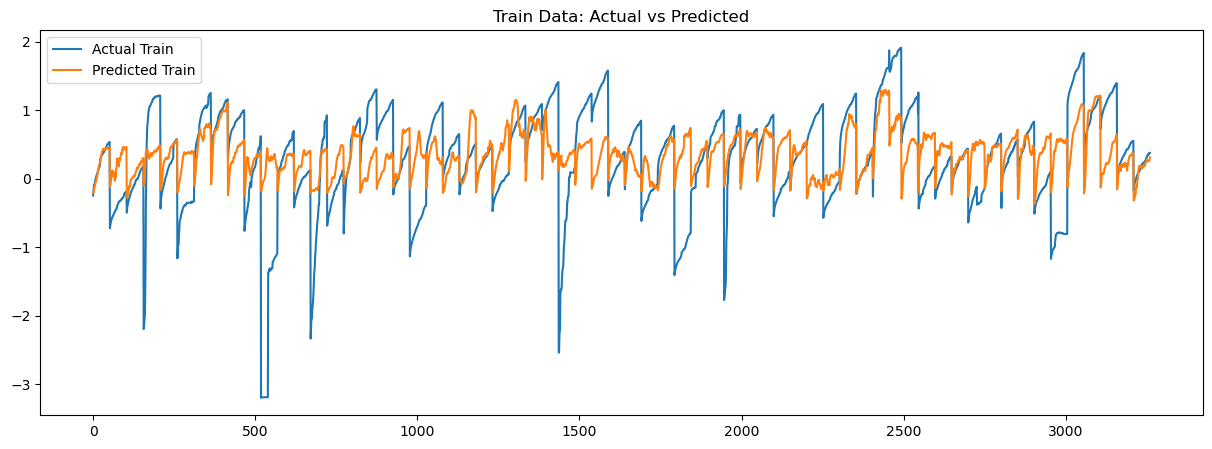

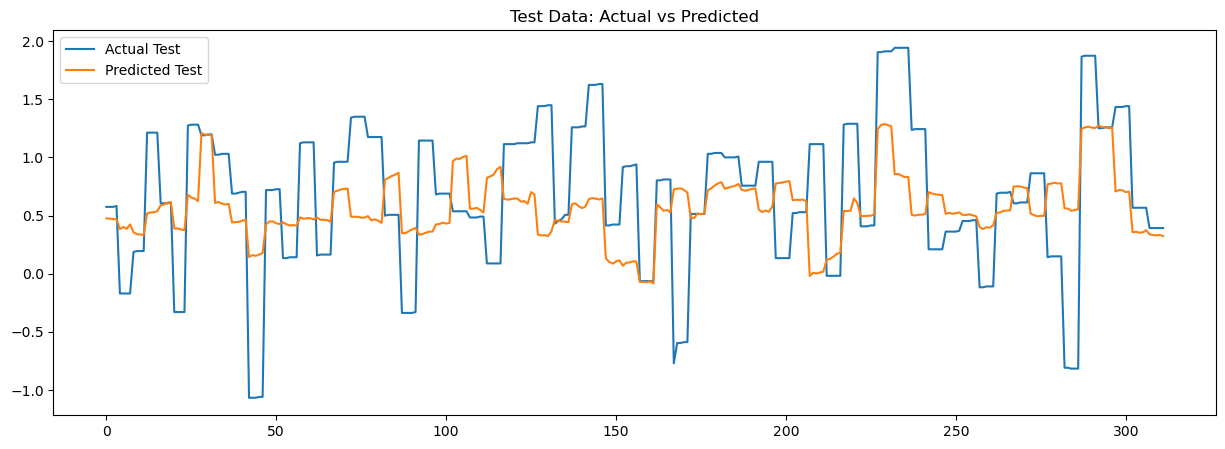

In [27]:
# Plotting train predictions and actual values
plt.figure(figsize=(15, 5))
plt.plot(range(len(y_train)), y_train, label='Actual Train')
plt.plot(range(len(train_pred)), train_pred, label='Predicted Train')
plt.title('Train Data: Actual vs Predicted')
plt.legend()
plt.show()

# Plotting test predictions and actual values
plt.figure(figsize=(15, 5))
plt.plot(range(len(y_test)), y_test, label='Actual Test')
plt.plot(range(len(test_pred)), test_pred, label='Predicted Test')
plt.title('Test Data: Actual vs Predicted')
plt.legend()
plt.show()

## No normalization 

In [57]:
# Import data
df = pd.read_csv('df_post_eda.csv')

# Convert 'Date' to datetime and sort by 'Date' and 'Location'
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date', 'Location'])

In [58]:
# Identify categorical columns except 'Location' (will be used to group)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove('Location')

# One-hot encode these categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# 'Date' and 'Location' as indices
df_encoded.set_index(['Date', 'Location'], inplace=True)

# Predictive variable
pred_var = 'Additional_Doses_Vax_Pct'

# Additional time-series columns to account for 3-month pattern
# 3 month lag
df_encoded['Additional_Doses_Vax_Pct_3_m_lag'] = df_encoded[pred_var].shift(12)

# 9 month lag
df_encoded['Additional_Doses_Vax_Pct_9_m_lag'] = df_encoded[pred_var].shift(36)

# Rolling statistics
df_encoded['rolling_mean'] = df_encoded[pred_var].shift().rolling(window=12).mean()
df_encoded['rolling_std'] = df_encoded[pred_var].shift().rolling(window=12).std()

# Split into train and test sets (before scaling to prevent leakage)
# 1080 because it represents around 20-30% of df and is a multiple of 12
test_size = 1080 
train_df = df_encoded.iloc[:-test_size]
test_df = df_encoded.iloc[-test_size:]

# Forward fill in missing values on rolling and lag features 

def process(df, target_var):
    lag_features = [col for col in df.columns if 'lag' in col or 'rolling' in col]
    df = df[[target_var] + lag_features]

    # First forward fill, then backward fill
    df = df.fillna(method='ffill').fillna(method='bfill')
    return df

# Process train and test sets separately
train_processed = process(train_df, pred_var)
test_processed = process(test_df, pred_var)

# Initialize an instance of MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

# Apply the scaler to the train and test data
train_scaled = pd.DataFrame(min_max_scaler.fit_transform(train_processed), columns=train_processed.columns, index=train_processed.index)
test_scaled = pd.DataFrame(min_max_scaler.transform(test_processed), columns=test_processed.columns, index=test_processed.index)


In [59]:
# Create sequences for LSTM
def make_series(data, sequence_length):
    series = []
    # Group data by 'Location' and create sequences for each location
    for location, group in data.groupby(level='Location'):
        group = group.reset_index(level='Location', drop=True)
        # Create sequences of specified length and corresponding target values
        for i in range(sequence_length, len(group)):
            sequence = group[i-sequence_length:i]
            target = group.iloc[i][pred_var]
            series.append((sequence.index[0], target, sequence.drop(pred_var, axis=1).values))
    return series

# Set sequence length to capture 3-month pattern
sequence_length = 12

# Create sequences for LSTM from the normalized data
train_series = make_series(train_scaled, sequence_length)
test_series = make_series(test_scaled, sequence_length)

# Prepare data for LSTM
x_train = np.array([x[2] for x in train_series])
y_train = np.array([x[1] for x in train_seres])

x_test = np.array([x[2] for x in test_series])
y_test = np.array([x[1] for x in test_series])

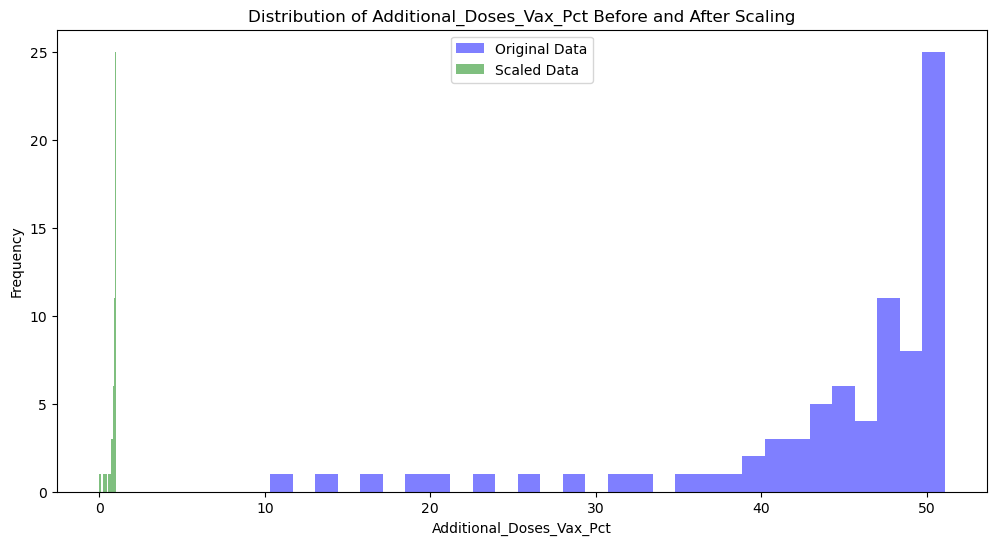

In [75]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load data
df = pd.read_csv('df_post_eda.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date', 'Location'])
pred_var = 'Additional_Doses_Vax_Pct'

# Group by 'Date' to ensure there is one unique value per date
df_grouped = df.groupby('Date').mean().reset_index()

# Original data distribution
original_data = df_grouped[pred_var]

# Apply MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = pd.DataFrame(scaler.fit_transform(df_grouped[[pred_var]]), columns=[pred_var])

# Plotting
plt.figure(figsize=(12, 6))
plt.hist(original_data, bins=30, alpha=0.5, label='Original Data', color='blue')
plt.hist(scaled_data[pred_var], bins=30, alpha=0.5, label='Scaled Data', color='green')
plt.title('Distribution of Additional_Doses_Vax_Pct Before and After Scaling')
plt.xlabel('Additional_Doses_Vax_Pct')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### Initial base model

In [61]:
# LSTM model with Dropout
inputs = Input(shape=(sequence_length, x_train.shape[2]))
lstm_out = LSTM(32, return_sequences=False)(inputs)
lstm_out = Dropout(0.2)(lstm_out)  # Add dropout
outputs = Dense(1)(lstm_out)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mae')

# Fit the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_test, y_test),  # Add validation data
    shuffle=False  # Do not shuffle time series data
)


Epoch 1/100
102/102 [==============================] - 3s 15ms/step - loss: 0.1917 - val_loss: 0.1194
Epoch 2/100
102/102 [==============================] - 1s 12ms/step - loss: 0.1498 - val_loss: 0.1068
Epoch 3/100
102/102 [==============================] - 1s 11ms/step - loss: 0.1393 - val_loss: 0.1169
Epoch 4/100
102/102 [==============================] - 1s 11ms/step - loss: 0.1339 - val_loss: 0.1062
Epoch 5/100
102/102 [==============================] - 1s 10ms/step - loss: 0.1299 - val_loss: 0.1183
Epoch 6/100
102/102 [==============================] - 1s 9ms/step - loss: 0.1273 - val_loss: 0.1026
Epoch 7/100
102/102 [==============================] - 1s 10ms/step - loss: 0.1258 - val_loss: 0.1020
Epoch 8/100
102/102 [==============================] - 1s 9ms/step - loss: 0.1263 - val_loss: 0.1048
Epoch 9/100
102/102 [==============================] - 1s 10ms/step - loss: 0.1251 - val_loss: 0.1059
Epoch 10/100
102/102 [==============================] - 1s 11ms/step - loss: 0.1241 

10/10 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Training Data: Actual vs Predicted')

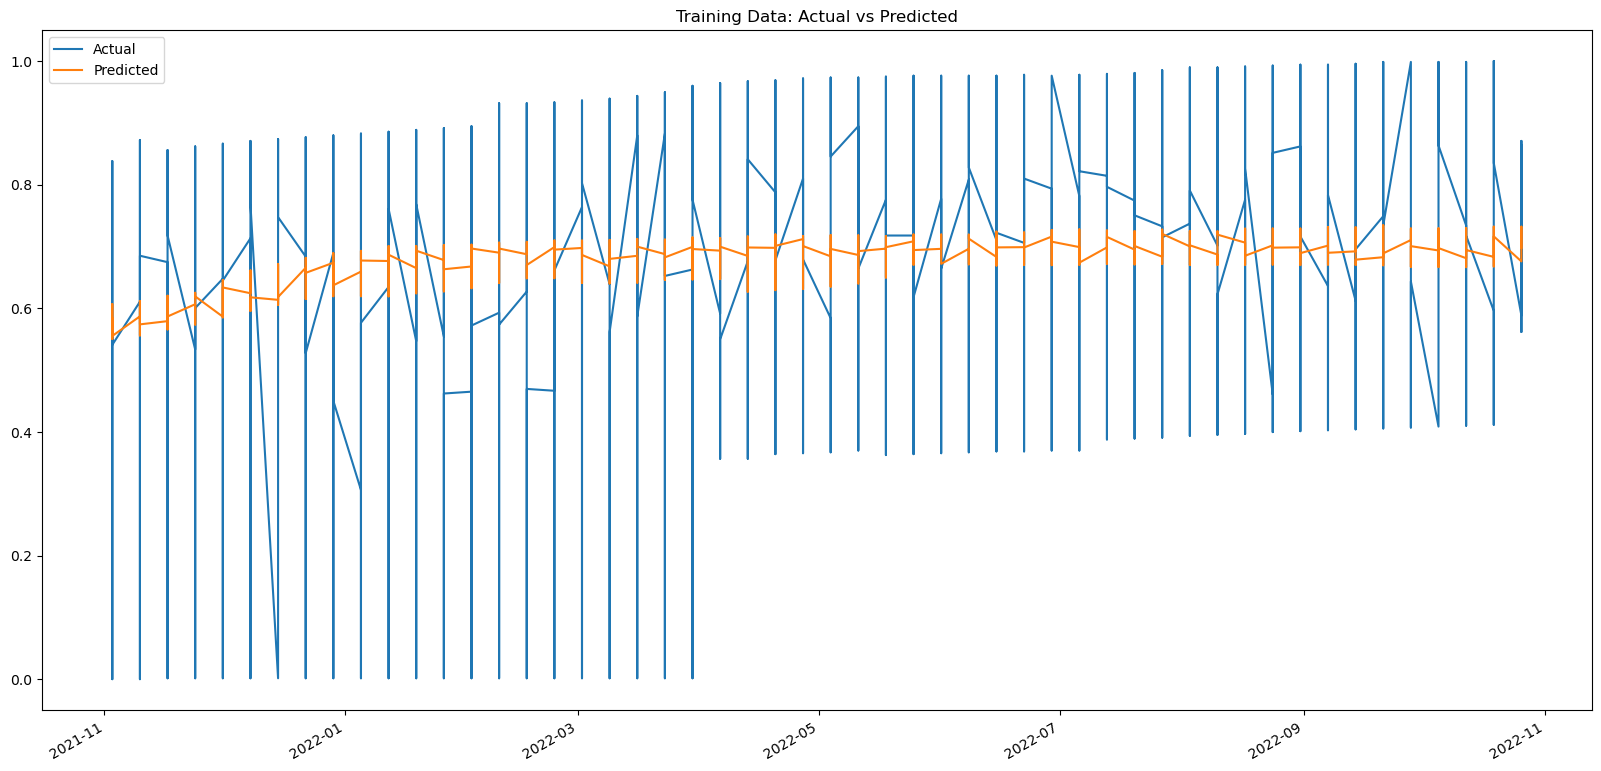

In [62]:
# Predictions
train_pred = model.predict(x_train).flatten()  # Flatten to ensure it's a 1D array
test_pred = model.predict(x_test).flatten()

# Create DataFrames for the actual and predicted values with proper indexing
# Ensure the index is constructed correctly for the training ground truth
train_indices = [x[0] for x in train_series]
train_gt = pd.DataFrame(y_train, columns=['y'], index=train_indices)
train_pred_df = pd.DataFrame(train_pred, columns=['yhat'], index=train_indices)

# Plot training predictions and actual values
pd.concat([train_gt, train_pred_df], axis=1).plot(figsize=(20,10))
plt.legend(['Actual', 'Predicted'])
plt.title('Training Data: Actual vs Predicted')


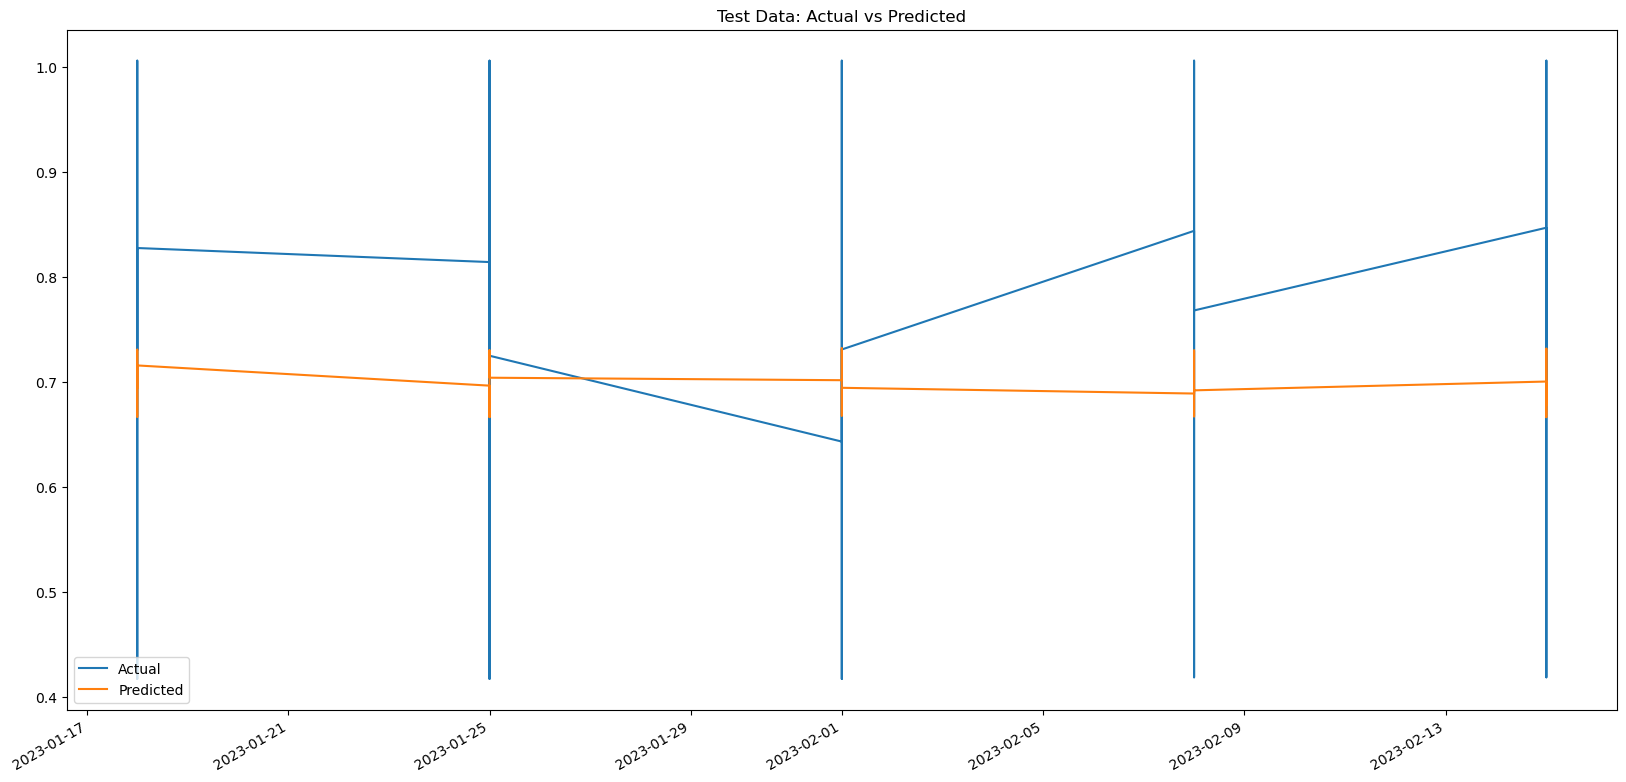

In [63]:
# Ensure the index is constructed correctly for the test ground truth
test_indices = [x[0] for x in test_series]
test_gt = pd.DataFrame(y_test, columns=['y'], index=test_indices)
test_pred_df = pd.DataFrame(test_pred, columns=['yhat'], index=test_indices)

# Plot test predictions and actual values
pd.concat([test_gt, test_pred_df], axis=1).plot(figsize=(20,10))
plt.legend(['Actual', 'Predicted'])
plt.title('Test Data: Actual vs Predicted')
plt.show()

In [64]:
# Calculate metrics
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)

test_mae = mean_absolute_error(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_r2 = r2_score(y_test, test_pred)

print("Training Metrics:")
print(f"MAE: {train_mae}")
print(f"RMSE: {train_rmse}")
print(f"R2: {train_r2}")

print("\nTest Metrics:")
print(f"MAE: {test_mae}")
print(f"RMSE: {test_rmse}")
print(f"R2: {test_r2}")

Training Metrics:
MAE: 0.10253838405888825
RMSE: 0.13471788574485136
R2: 0.10255196178358728

Test Metrics:
MAE: 0.11171578808165002
RMSE: 0.13584141339333564
R2: -0.22723656606243847


### Tuned model

In [65]:
# Learning rate scheduler for training
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1 * (epoch // 10))  # More aggressive decay every 10 epochs

# Function to build LSTM model
def build_model(input_shape, output_units=1, neurons=16, dropout=0.3, l1_reg=0.0001, l2_reg=0.0001):
    model = Sequential()
    # LSTM layer with dropout and regularization
    model.add(LSTM(neurons, return_sequences=True, input_shape=input_shape,
                   kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(Dropout(dropout))
    # LSTM layer with dropout and regularization
    model.add(LSTM(neurons, return_sequences=False, 
                   kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(Dropout(dropout))
    # Output layer with sigmoid activation for outputs between 0 and 1
    model.add(Dense(output_units, activation='sigmoid'))
    
    # Compile model with MAE loss and Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')
    return model


In [66]:
# Callbacks for training
lr_schedule = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Hyperparameters to iterate over
neurons_options = [16, 32]
dropout_options = [0.2, 0.3]
l1_reg_options = [0.0001, 0.00001]
l2_reg_options = [0.0001, 0.00001]
batch_sizes = [32, 64, 128]

# Initialize variables to track the best model configuration
best_val_loss = float('inf')
best_config = {}

# Input shape for LSTM layers
input_shape = (sequence_length, x_train.shape[2])

# Loop over all combinations of hyperparameters
for neurons in neurons_options:
    for dropout in dropout_options:
        for l1_reg in l1_reg_options:
            for l2_reg in l2_reg_options:
                for batch_size in batch_sizes:
                    print(f"Training with neurons: {neurons}, dropout: {dropout}, l1_reg: {l1_reg}, l2_reg: {l2_reg}, batch_size: {batch_size}")
                    
                    # Build the model with current hyperparameters
                    model = build_model(input_shape, output_units=1, neurons=neurons, dropout=dropout, l1_reg=l1_reg, l2_reg=l2_reg)
                    
                    # Save the best model during training
                    checkpoint_filepath = f'./best_model_{neurons}_{dropout}_{l1_reg}_{l2_reg}_{batch_size}.h5'
                    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
                    
                    # Train the model
                    history = model.fit(x_train, y_train, epochs=100, batch_size=batch_size, validation_data=(x_test, y_test), shuffle=False, callbacks=[lr_schedule, early_stopping, model_checkpoint_callback])
                    
                    # Update the best model configuration if the current one is better
                    min_val_loss = min(history.history['val_loss'])
                    if min_val_loss < best_val_loss:
                        best_val_loss = min_val_loss
                        best_config = {'neurons': neurons, 'dropout': dropout, 'l1_reg': l1_reg, 'l2_reg': l2_reg, 'batch_size': batch_size, 'filepath': checkpoint_filepath}
                        
                    print(f"Best Validation Loss: {best_val_loss}")
                    print(f"Best Configuration: {best_config}")

# Build and train the model using the best configuration
model = build_model(input_shape, output_units=1, neurons=best_config['neurons'], dropout=best_config['dropout'], l1_reg=best_config['l1_reg'], l2_reg=best_config['l2_reg'])
model.load_weights(best_config['filepath'])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Train the model with the best configuration
model.fit(x_train, y_train, epochs=100, batch_size=best_config['batch_size'], validation_data=(x_test, y_test), shuffle=False, callbacks=[lr_schedule, early_stopping])

# Make predictions with the trained model
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

# Calculate and print performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"Training Metrics: MAE: {mean_absolute_error(y_train, train_pred)}, RMSE: {train_rmse}")
print(f"Testing Metrics: MAE: {mean_absolute_error(y_test, test_pred)}, RMSE: {test_rmse}")

Training with neurons: 16, dropout: 0.2, l1_reg: 0.0001, l2_reg: 0.0001, batch_size: 32
Epoch 1/100
102/102 [==============================] - 11s 66ms/step - loss: 0.1336 - val_loss: 0.1309 - lr: 0.0010
Epoch 2/100
102/102 [==============================] - 3s 28ms/step - loss: 0.1270 - val_loss: 0.1304 - lr: 0.0010
Epoch 3/100
102/102 [==============================] - 2s 20ms/step - loss: 0.1246 - val_loss: 0.1268 - lr: 0.0010
Epoch 4/100
102/102 [==============================] - 3s 32ms/step - loss: 0.1230 - val_loss: 0.1256 - lr: 0.0010
Epoch 5/100
102/102 [==============================] - 4s 35ms/step - loss: 0.1212 - val_loss: 0.1278 - lr: 0.0010
Epoch 6/100
102/102 [==============================] - 5s 44ms/step - loss: 0.1196 - val_loss: 0.1253 - lr: 0.0010
Epoch 7/100
102/102 [==============================] - 3s 32ms/step - loss: 0.1192 - val_loss: 0.1225 - lr: 0.0010
Epoch 8/100
102/102 [==============================] - 4s 35ms/step - loss: 0.1186 - val_loss: 0.1199 - lr

Epoch 7/100
51/51 [==============================] - 2s 32ms/step - loss: 0.1205 - val_loss: 0.1159 - lr: 0.0010
Epoch 8/100
51/51 [==============================] - 1s 29ms/step - loss: 0.1208 - val_loss: 0.1177 - lr: 0.0010
Epoch 9/100
51/51 [==============================] - 2s 31ms/step - loss: 0.1190 - val_loss: 0.1157 - lr: 0.0010
Epoch 10/100
51/51 [==============================] - 2s 33ms/step - loss: 0.1194 - val_loss: 0.1160 - lr: 0.0010
Epoch 11/100
51/51 [==============================] - 2s 35ms/step - loss: 0.1185 - val_loss: 0.1141 - lr: 9.0484e-04
Epoch 12/100
51/51 [==============================] - 2s 34ms/step - loss: 0.1181 - val_loss: 0.1147 - lr: 8.1873e-04
Epoch 13/100
51/51 [==============================] - 2s 38ms/step - loss: 0.1183 - val_loss: 0.1146 - lr: 7.4082e-04
Epoch 14/100
51/51 [==============================] - 2s 32ms/step - loss: 0.1166 - val_loss: 0.1139 - lr: 6.7032e-04
Epoch 15/100
51/51 [==============================] - 2s 30ms/step - loss: 

51/51 [==============================] - 2s 32ms/step - loss: 0.1234 - val_loss: 0.1184 - lr: 0.0010
Epoch 6/100
51/51 [==============================] - 2s 30ms/step - loss: 0.1224 - val_loss: 0.1173 - lr: 0.0010
Epoch 7/100
51/51 [==============================] - 2s 33ms/step - loss: 0.1216 - val_loss: 0.1172 - lr: 0.0010
Epoch 8/100
51/51 [==============================] - 2s 35ms/step - loss: 0.1213 - val_loss: 0.1166 - lr: 0.0010
Epoch 9/100
51/51 [==============================] - 2s 33ms/step - loss: 0.1201 - val_loss: 0.1162 - lr: 0.0010
Epoch 10/100
51/51 [==============================] - 2s 33ms/step - loss: 0.1200 - val_loss: 0.1154 - lr: 0.0010
Epoch 11/100
51/51 [==============================] - 1s 27ms/step - loss: 0.1192 - val_loss: 0.1147 - lr: 9.0484e-04
Epoch 12/100
51/51 [==============================] - 1s 28ms/step - loss: 0.1179 - val_loss: 0.1132 - lr: 8.1873e-04
Epoch 13/100
51/51 [==============================] - 1s 27ms/step - loss: 0.1175 - val_loss: 0.1

Epoch 35/100
26/26 [==============================] - 1s 46ms/step - loss: 0.1148 - val_loss: 0.1149 - lr: 1.1109e-05
Epoch 36/100
26/26 [==============================] - 2s 62ms/step - loss: 0.1152 - val_loss: 0.1149 - lr: 8.2297e-06
Epoch 37/100
26/26 [==============================] - 1s 54ms/step - loss: 0.1157 - val_loss: 0.1149 - lr: 6.0967e-06
Best Validation Loss: 0.10912801325321198
Best Configuration: {'neurons': 16, 'dropout': 0.2, 'l1_reg': 0.0001, 'l2_reg': 1e-05, 'batch_size': 32, 'filepath': './best_model_16_0.2_0.0001_1e-05_32.h5'}
Training with neurons: 16, dropout: 0.2, l1_reg: 1e-05, l2_reg: 0.0001, batch_size: 32
Epoch 1/100
102/102 [==============================] - 15s 61ms/step - loss: 0.1199 - val_loss: 0.1178 - lr: 0.0010
Epoch 2/100
102/102 [==============================] - 4s 44ms/step - loss: 0.1140 - val_loss: 0.1194 - lr: 0.0010
Epoch 3/100
102/102 [==============================] - 4s 41ms/step - loss: 0.1135 - val_loss: 0.1185 - lr: 0.0010
Epoch 4/100


102/102 [==============================] - 2s 22ms/step - loss: 0.1103 - val_loss: 0.1098 - lr: 9.0484e-04
Epoch 12/100
102/102 [==============================] - 3s 32ms/step - loss: 0.1099 - val_loss: 0.1090 - lr: 8.1873e-04
Epoch 13/100
102/102 [==============================] - 2s 21ms/step - loss: 0.1103 - val_loss: 0.1089 - lr: 7.4082e-04
Epoch 14/100
102/102 [==============================] - 3s 26ms/step - loss: 0.1096 - val_loss: 0.1091 - lr: 6.7032e-04
Epoch 15/100
102/102 [==============================] - 3s 30ms/step - loss: 0.1087 - val_loss: 0.1081 - lr: 6.0653e-04
Epoch 16/100
102/102 [==============================] - 3s 28ms/step - loss: 0.1093 - val_loss: 0.1072 - lr: 5.4881e-04
Epoch 17/100
102/102 [==============================] - 2s 21ms/step - loss: 0.1087 - val_loss: 0.1069 - lr: 4.9659e-04
Epoch 18/100
102/102 [==============================] - 2s 20ms/step - loss: 0.1085 - val_loss: 0.1073 - lr: 4.4933e-04
Epoch 19/100
102/102 [==============================]

Epoch 30/100
51/51 [==============================] - 1s 25ms/step - loss: 0.1078 - val_loss: 0.1054 - lr: 4.9787e-05
Epoch 31/100
51/51 [==============================] - 1s 22ms/step - loss: 0.1071 - val_loss: 0.1053 - lr: 3.6883e-05
Epoch 32/100
51/51 [==============================] - 1s 22ms/step - loss: 0.1070 - val_loss: 0.1054 - lr: 2.7324e-05
Epoch 33/100
51/51 [==============================] - 1s 25ms/step - loss: 0.1070 - val_loss: 0.1054 - lr: 2.0242e-05
Epoch 34/100
51/51 [==============================] - 1s 24ms/step - loss: 0.1068 - val_loss: 0.1054 - lr: 1.4996e-05
Epoch 35/100
51/51 [==============================] - 1s 26ms/step - loss: 0.1073 - val_loss: 0.1055 - lr: 1.1109e-05
Epoch 36/100
51/51 [==============================] - 1s 26ms/step - loss: 0.1064 - val_loss: 0.1055 - lr: 8.2297e-06
Epoch 37/100
51/51 [==============================] - 1s 26ms/step - loss: 0.1070 - val_loss: 0.1055 - lr: 6.0967e-06
Best Validation Loss: 0.10450927913188934
Best Configura

Epoch 37/100
102/102 [==============================] - 2s 21ms/step - loss: 0.1106 - val_loss: 0.1099 - lr: 6.0967e-06
Epoch 38/100
102/102 [==============================] - 3s 27ms/step - loss: 0.1107 - val_loss: 0.1099 - lr: 4.5166e-06
Epoch 39/100
102/102 [==============================] - 3s 27ms/step - loss: 0.1109 - val_loss: 0.1099 - lr: 3.3460e-06
Epoch 40/100
102/102 [==============================] - 3s 26ms/step - loss: 0.1099 - val_loss: 0.1098 - lr: 2.4788e-06
Epoch 41/100
102/102 [==============================] - 2s 20ms/step - loss: 0.1104 - val_loss: 0.1098 - lr: 1.6616e-06
Epoch 42/100
102/102 [==============================] - 2s 22ms/step - loss: 0.1110 - val_loss: 0.1098 - lr: 1.1138e-06
Epoch 43/100
102/102 [==============================] - 3s 34ms/step - loss: 0.1104 - val_loss: 0.1098 - lr: 7.4659e-07
Epoch 44/100
102/102 [==============================] - 4s 34ms/step - loss: 0.1107 - val_loss: 0.1098 - lr: 5.0045e-07
Epoch 45/100
102/102 [==================

Epoch 40/100
102/102 [==============================] - 2s 22ms/step - loss: 0.1112 - val_loss: 0.1105 - lr: 2.4788e-06
Epoch 41/100
102/102 [==============================] - 3s 33ms/step - loss: 0.1116 - val_loss: 0.1105 - lr: 1.6616e-06
Epoch 42/100
102/102 [==============================] - 3s 32ms/step - loss: 0.1109 - val_loss: 0.1105 - lr: 1.1138e-06
Epoch 43/100
102/102 [==============================] - 3s 28ms/step - loss: 0.1115 - val_loss: 0.1105 - lr: 7.4659e-07
Epoch 44/100
102/102 [==============================] - 2s 24ms/step - loss: 0.1109 - val_loss: 0.1105 - lr: 5.0045e-07
Epoch 45/100
102/102 [==============================] - 2s 19ms/step - loss: 0.1110 - val_loss: 0.1105 - lr: 3.3546e-07
Best Validation Loss: 0.10382858663797379
Best Configuration: {'neurons': 16, 'dropout': 0.2, 'l1_reg': 1e-05, 'l2_reg': 1e-05, 'batch_size': 128, 'filepath': './best_model_16_0.2_1e-05_1e-05_128.h5'}
Training with neurons: 16, dropout: 0.3, l1_reg: 0.0001, l2_reg: 1e-05, batch_s

Epoch 41/100
102/102 [==============================] - 4s 35ms/step - loss: 0.1080 - val_loss: 0.1070 - lr: 1.6616e-06
Epoch 42/100
102/102 [==============================] - 3s 32ms/step - loss: 0.1077 - val_loss: 0.1070 - lr: 1.1138e-06
Epoch 43/100
102/102 [==============================] - 3s 33ms/step - loss: 0.1072 - val_loss: 0.1070 - lr: 7.4659e-07
Epoch 44/100
102/102 [==============================] - 4s 35ms/step - loss: 0.1080 - val_loss: 0.1070 - lr: 5.0045e-07
Epoch 45/100
102/102 [==============================] - 3s 30ms/step - loss: 0.1078 - val_loss: 0.1070 - lr: 3.3546e-07
Epoch 46/100
102/102 [==============================] - 4s 35ms/step - loss: 0.1075 - val_loss: 0.1070 - lr: 2.2487e-07
Epoch 47/100
102/102 [==============================] - 4s 35ms/step - loss: 0.1086 - val_loss: 0.1070 - lr: 1.5073e-07
Epoch 48/100
102/102 [==============================] - 3s 27ms/step - loss: 0.1079 - val_loss: 0.1070 - lr: 1.0104e-07
Epoch 49/100
102/102 [==================

Epoch 13/100
102/102 [==============================] - 3s 24ms/step - loss: 0.1105 - val_loss: 0.1083 - lr: 7.4082e-04
Epoch 14/100
102/102 [==============================] - 2s 24ms/step - loss: 0.1096 - val_loss: 0.1078 - lr: 6.7032e-04
Epoch 15/100
102/102 [==============================] - 3s 28ms/step - loss: 0.1101 - val_loss: 0.1076 - lr: 6.0653e-04
Epoch 16/100
102/102 [==============================] - 3s 29ms/step - loss: 0.1089 - val_loss: 0.1068 - lr: 5.4881e-04
Epoch 17/100
102/102 [==============================] - 2s 24ms/step - loss: 0.1087 - val_loss: 0.1057 - lr: 4.9659e-04
Epoch 18/100
102/102 [==============================] - 2s 22ms/step - loss: 0.1099 - val_loss: 0.1062 - lr: 4.4933e-04
Epoch 19/100
102/102 [==============================] - 2s 24ms/step - loss: 0.1083 - val_loss: 0.1063 - lr: 4.0657e-04
Epoch 20/100
102/102 [==============================] - 3s 26ms/step - loss: 0.1080 - val_loss: 0.1061 - lr: 3.6788e-04
Epoch 21/100
102/102 [==================

Epoch 33/100
51/51 [==============================] - 1s 23ms/step - loss: 0.1088 - val_loss: 0.1066 - lr: 2.0242e-05
Epoch 34/100
51/51 [==============================] - 2s 41ms/step - loss: 0.1075 - val_loss: 0.1066 - lr: 1.4996e-05
Best Validation Loss: 0.10382858663797379
Best Configuration: {'neurons': 16, 'dropout': 0.2, 'l1_reg': 1e-05, 'l2_reg': 1e-05, 'batch_size': 128, 'filepath': './best_model_16_0.2_1e-05_1e-05_128.h5'}
Training with neurons: 16, dropout: 0.3, l1_reg: 1e-05, l2_reg: 1e-05, batch_size: 128
Epoch 1/100
26/26 [==============================] - 11s 118ms/step - loss: 0.1472 - val_loss: 0.1090 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 1s 35ms/step - loss: 0.1124 - val_loss: 0.1073 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 1s 36ms/step - loss: 0.1129 - val_loss: 0.1080 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 1s 40ms/step - loss: 0.1110 - val_loss: 0.1069 - lr: 0.0010
Epoch 5/100
26/26 [===

Epoch 30/100
102/102 [==============================] - 3s 34ms/step - loss: 0.1095 - val_loss: 0.1096 - lr: 4.9787e-05
Epoch 31/100
102/102 [==============================] - 5s 49ms/step - loss: 0.1092 - val_loss: 0.1095 - lr: 3.6883e-05
Epoch 32/100
102/102 [==============================] - 4s 40ms/step - loss: 0.1098 - val_loss: 0.1095 - lr: 2.7324e-05
Epoch 33/100
102/102 [==============================] - 4s 35ms/step - loss: 0.1095 - val_loss: 0.1096 - lr: 2.0242e-05
Epoch 34/100
102/102 [==============================] - 3s 34ms/step - loss: 0.1094 - val_loss: 0.1096 - lr: 1.4996e-05
Epoch 35/100
102/102 [==============================] - 5s 47ms/step - loss: 0.1089 - val_loss: 0.1096 - lr: 1.1109e-05
Epoch 36/100
102/102 [==============================] - 5s 46ms/step - loss: 0.1090 - val_loss: 0.1095 - lr: 8.2297e-06
Epoch 37/100
102/102 [==============================] - 7s 67ms/step - loss: 0.1090 - val_loss: 0.1095 - lr: 6.0967e-06
Epoch 38/100
102/102 [==================

Epoch 3/100
26/26 [==============================] - 1s 36ms/step - loss: 0.1480 - val_loss: 0.1397 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 1s 33ms/step - loss: 0.1423 - val_loss: 0.1351 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 1s 32ms/step - loss: 0.1391 - val_loss: 0.1315 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 1s 33ms/step - loss: 0.1349 - val_loss: 0.1290 - lr: 0.0010
Epoch 7/100
26/26 [==============================] - 1s 36ms/step - loss: 0.1326 - val_loss: 0.1260 - lr: 0.0010
Epoch 8/100
26/26 [==============================] - 1s 38ms/step - loss: 0.1304 - val_loss: 0.1239 - lr: 0.0010
Epoch 9/100
26/26 [==============================] - 1s 52ms/step - loss: 0.1286 - val_loss: 0.1219 - lr: 0.0010
Epoch 10/100
26/26 [==============================] - 1s 37ms/step - loss: 0.1267 - val_loss: 0.1224 - lr: 0.0010
Epoch 11/100
26/26 [==============================] - 1s 41ms/step - loss: 0.1258 - val_loss: 0

Epoch 27/100
51/51 [==============================] - 1s 22ms/step - loss: 0.1133 - val_loss: 0.1121 - lr: 9.0718e-05
Epoch 28/100
51/51 [==============================] - 1s 22ms/step - loss: 0.1131 - val_loss: 0.1121 - lr: 7.4274e-05
Epoch 29/100
51/51 [==============================] - 1s 24ms/step - loss: 0.1128 - val_loss: 0.1120 - lr: 6.0810e-05
Epoch 30/100
51/51 [==============================] - 1s 27ms/step - loss: 0.1125 - val_loss: 0.1118 - lr: 4.9787e-05
Epoch 31/100
51/51 [==============================] - 1s 27ms/step - loss: 0.1127 - val_loss: 0.1118 - lr: 3.6883e-05
Epoch 32/100
51/51 [==============================] - 1s 29ms/step - loss: 0.1126 - val_loss: 0.1118 - lr: 2.7324e-05
Epoch 33/100
51/51 [==============================] - 1s 28ms/step - loss: 0.1125 - val_loss: 0.1118 - lr: 2.0242e-05
Epoch 34/100
51/51 [==============================] - 1s 22ms/step - loss: 0.1125 - val_loss: 0.1118 - lr: 1.4996e-05
Epoch 35/100
51/51 [==============================] - 1s

Epoch 23/100
51/51 [==============================] - 1s 23ms/step - loss: 0.1091 - val_loss: 0.1071 - lr: 2.0190e-04
Epoch 24/100
51/51 [==============================] - 1s 24ms/step - loss: 0.1086 - val_loss: 0.1069 - lr: 1.6530e-04
Epoch 25/100
51/51 [==============================] - 1s 23ms/step - loss: 0.1081 - val_loss: 0.1072 - lr: 1.3534e-04
Epoch 26/100
51/51 [==============================] - 1s 23ms/step - loss: 0.1087 - val_loss: 0.1074 - lr: 1.1080e-04
Epoch 27/100
51/51 [==============================] - 1s 22ms/step - loss: 0.1076 - val_loss: 0.1074 - lr: 9.0718e-05
Epoch 28/100
51/51 [==============================] - 1s 23ms/step - loss: 0.1083 - val_loss: 0.1073 - lr: 7.4274e-05
Epoch 29/100
51/51 [==============================] - 1s 25ms/step - loss: 0.1082 - val_loss: 0.1070 - lr: 6.0810e-05
Epoch 30/100
51/51 [==============================] - 1s 29ms/step - loss: 0.1076 - val_loss: 0.1070 - lr: 4.9787e-05
Epoch 31/100
51/51 [==============================] - 2s

102/102 [==============================] - 2s 20ms/step - loss: 0.1128 - val_loss: 0.1175 - lr: 0.0010
Epoch 5/100
102/102 [==============================] - 2s 23ms/step - loss: 0.1116 - val_loss: 0.1174 - lr: 0.0010
Epoch 6/100
102/102 [==============================] - 3s 32ms/step - loss: 0.1116 - val_loss: 0.1183 - lr: 0.0010
Epoch 7/100
102/102 [==============================] - 3s 34ms/step - loss: 0.1110 - val_loss: 0.1166 - lr: 0.0010
Epoch 8/100
102/102 [==============================] - 3s 33ms/step - loss: 0.1118 - val_loss: 0.1156 - lr: 0.0010
Epoch 9/100
102/102 [==============================] - 4s 38ms/step - loss: 0.1104 - val_loss: 0.1159 - lr: 0.0010
Epoch 10/100
102/102 [==============================] - 3s 31ms/step - loss: 0.1103 - val_loss: 0.1153 - lr: 0.0010
Epoch 11/100
102/102 [==============================] - 3s 25ms/step - loss: 0.1101 - val_loss: 0.1152 - lr: 9.0484e-04
Epoch 12/100
102/102 [==============================] - 2s 20ms/step - loss: 0.1098 - 

102/102 [==============================] - 3s 34ms/step - loss: 0.1121 - val_loss: 0.1121 - lr: 3.0119e-04
Epoch 22/100
102/102 [==============================] - 3s 34ms/step - loss: 0.1114 - val_loss: 0.1111 - lr: 2.4660e-04
Epoch 23/100
102/102 [==============================] - 3s 29ms/step - loss: 0.1120 - val_loss: 0.1108 - lr: 2.0190e-04
Epoch 24/100
102/102 [==============================] - 3s 27ms/step - loss: 0.1112 - val_loss: 0.1103 - lr: 1.6530e-04
Epoch 25/100
102/102 [==============================] - 2s 23ms/step - loss: 0.1109 - val_loss: 0.1104 - lr: 1.3534e-04
Epoch 26/100
102/102 [==============================] - 2s 22ms/step - loss: 0.1109 - val_loss: 0.1100 - lr: 1.1080e-04
Epoch 27/100
102/102 [==============================] - 3s 29ms/step - loss: 0.1114 - val_loss: 0.1102 - lr: 9.0718e-05
Epoch 28/100
102/102 [==============================] - 3s 33ms/step - loss: 0.1102 - val_loss: 0.1101 - lr: 7.4274e-05
Epoch 29/100
102/102 [==============================]

Epoch 31/100
51/51 [==============================] - 2s 37ms/step - loss: 0.1139 - val_loss: 0.1126 - lr: 3.6883e-05
Epoch 32/100
51/51 [==============================] - 2s 41ms/step - loss: 0.1141 - val_loss: 0.1126 - lr: 2.7324e-05
Epoch 33/100
51/51 [==============================] - 2s 38ms/step - loss: 0.1148 - val_loss: 0.1126 - lr: 2.0242e-05
Epoch 34/100
51/51 [==============================] - 2s 39ms/step - loss: 0.1138 - val_loss: 0.1126 - lr: 1.4996e-05
Epoch 35/100
51/51 [==============================] - 2s 34ms/step - loss: 0.1138 - val_loss: 0.1126 - lr: 1.1109e-05
Epoch 36/100
51/51 [==============================] - 2s 33ms/step - loss: 0.1143 - val_loss: 0.1126 - lr: 8.2297e-06
Epoch 37/100
51/51 [==============================] - 2s 32ms/step - loss: 0.1129 - val_loss: 0.1126 - lr: 6.0967e-06
Epoch 38/100
51/51 [==============================] - 2s 34ms/step - loss: 0.1143 - val_loss: 0.1126 - lr: 4.5166e-06
Epoch 39/100
51/51 [==============================] - 2s

Epoch 1/100
102/102 [==============================] - 15s 87ms/step - loss: 0.1545 - val_loss: 0.1460 - lr: 0.0010
Epoch 2/100
102/102 [==============================] - 4s 35ms/step - loss: 0.1400 - val_loss: 0.1408 - lr: 0.0010
Epoch 3/100
102/102 [==============================] - 4s 35ms/step - loss: 0.1320 - val_loss: 0.1338 - lr: 0.0010
Epoch 4/100
102/102 [==============================] - 3s 34ms/step - loss: 0.1291 - val_loss: 0.1320 - lr: 0.0010
Epoch 5/100
102/102 [==============================] - 3s 32ms/step - loss: 0.1261 - val_loss: 0.1320 - lr: 0.0010
Epoch 6/100
102/102 [==============================] - 4s 39ms/step - loss: 0.1234 - val_loss: 0.1258 - lr: 0.0010
Epoch 7/100
102/102 [==============================] - 4s 36ms/step - loss: 0.1218 - val_loss: 0.1262 - lr: 0.0010
Epoch 8/100
102/102 [==============================] - 3s 32ms/step - loss: 0.1213 - val_loss: 0.1253 - lr: 0.0010
Epoch 9/100
102/102 [==============================] - 4s 43ms/step - loss: 0.1

51/51 [==============================] - 2s 30ms/step - loss: 0.1151 - val_loss: 0.1131 - lr: 3.0119e-04
Epoch 22/100
51/51 [==============================] - 1s 29ms/step - loss: 0.1148 - val_loss: 0.1132 - lr: 2.4660e-04
Epoch 23/100
51/51 [==============================] - 2s 33ms/step - loss: 0.1147 - val_loss: 0.1132 - lr: 2.0190e-04
Epoch 24/100
51/51 [==============================] - 2s 36ms/step - loss: 0.1143 - val_loss: 0.1125 - lr: 1.6530e-04
Epoch 25/100
51/51 [==============================] - 2s 31ms/step - loss: 0.1140 - val_loss: 0.1127 - lr: 1.3534e-04
Epoch 26/100
51/51 [==============================] - 2s 33ms/step - loss: 0.1140 - val_loss: 0.1122 - lr: 1.1080e-04
Epoch 27/100
51/51 [==============================] - 2s 34ms/step - loss: 0.1142 - val_loss: 0.1121 - lr: 9.0718e-05
Epoch 28/100
51/51 [==============================] - 2s 34ms/step - loss: 0.1143 - val_loss: 0.1123 - lr: 7.4274e-05
Epoch 29/100
51/51 [==============================] - 2s 36ms/step - 

Epoch 1/100
51/51 [==============================] - 6s 40ms/step - loss: 0.1219 - val_loss: 0.1191 - lr: 0.0010
Epoch 2/100
51/51 [==============================] - 2s 30ms/step - loss: 0.1193 - val_loss: 0.1164 - lr: 0.0010
Epoch 3/100
51/51 [==============================] - 1s 27ms/step - loss: 0.1186 - val_loss: 0.1136 - lr: 0.0010
Epoch 4/100
51/51 [==============================] - 2s 37ms/step - loss: 0.1181 - val_loss: 0.1126 - lr: 0.0010
Epoch 5/100
51/51 [==============================] - 2s 31ms/step - loss: 0.1177 - val_loss: 0.1144 - lr: 0.0010
Epoch 6/100
51/51 [==============================] - 1s 27ms/step - loss: 0.1157 - val_loss: 0.1121 - lr: 0.0010
Epoch 7/100
51/51 [==============================] - 2s 31ms/step - loss: 0.1149 - val_loss: 0.1112 - lr: 0.0010
Epoch 8/100
51/51 [==============================] - 2s 30ms/step - loss: 0.1141 - val_loss: 0.1134 - lr: 0.0010
Epoch 9/100
51/51 [==============================] - 2s 30ms/step - loss: 0.1141 - val_loss: 0.1

Epoch 29/100
26/26 [==============================] - 1s 33ms/step - loss: 0.1098 - val_loss: 0.1079 - lr: 6.0810e-05
Epoch 30/100
26/26 [==============================] - 1s 35ms/step - loss: 0.1094 - val_loss: 0.1078 - lr: 4.9787e-05
Epoch 31/100
26/26 [==============================] - 1s 36ms/step - loss: 0.1096 - val_loss: 0.1078 - lr: 3.6883e-05
Epoch 32/100
26/26 [==============================] - 1s 35ms/step - loss: 0.1101 - val_loss: 0.1078 - lr: 2.7324e-05
Epoch 33/100
26/26 [==============================] - 1s 34ms/step - loss: 0.1099 - val_loss: 0.1079 - lr: 2.0242e-05
Epoch 34/100
26/26 [==============================] - 1s 37ms/step - loss: 0.1099 - val_loss: 0.1079 - lr: 1.4996e-05
Epoch 35/100
26/26 [==============================] - 1s 35ms/step - loss: 0.1100 - val_loss: 0.1079 - lr: 1.1109e-05
Epoch 36/100
26/26 [==============================] - 1s 28ms/step - loss: 0.1102 - val_loss: 0.1079 - lr: 8.2297e-06
Epoch 37/100
26/26 [==============================] - 1s

Epoch 26/100
26/26 [==============================] - 1s 33ms/step - loss: 0.1089 - val_loss: 0.1064 - lr: 1.1080e-04
Epoch 27/100
26/26 [==============================] - 1s 31ms/step - loss: 0.1085 - val_loss: 0.1065 - lr: 9.0718e-05
Epoch 28/100
26/26 [==============================] - 1s 30ms/step - loss: 0.1082 - val_loss: 0.1066 - lr: 7.4274e-05
Epoch 29/100
26/26 [==============================] - 1s 36ms/step - loss: 0.1084 - val_loss: 0.1064 - lr: 6.0810e-05
Epoch 30/100
26/26 [==============================] - 1s 36ms/step - loss: 0.1081 - val_loss: 0.1062 - lr: 4.9787e-05
Epoch 31/100
26/26 [==============================] - 1s 38ms/step - loss: 0.1083 - val_loss: 0.1062 - lr: 3.6883e-05
Best Validation Loss: 0.10356340557336807
Best Configuration: {'neurons': 32, 'dropout': 0.2, 'l1_reg': 1e-05, 'l2_reg': 1e-05, 'batch_size': 128, 'filepath': './best_model_32_0.2_1e-05_1e-05_128.h5'}
Epoch 1/100
26/26 [==============================] - 9s 65ms/step - loss: 0.1155 - val_loss

In [67]:
# Calculate metrics
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)

test_mae = mean_absolute_error(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_r2 = r2_score(y_test, test_pred)

print("Training Metrics:")
print(f"MAE: {train_mae}")
print(f"RMSE: {train_rmse}")
print(f"R2: {train_r2}")

print("\nTest Metrics:")
print(f"MAE: {test_mae}")
print(f"RMSE: {test_rmse}")
print(f"R2: {test_r2}")

Training Metrics:
MAE: 0.10306679728997796
RMSE: 0.13706277271032366
R2: 0.07103827205993163

Test Metrics:
MAE: 0.1020198512920181
RMSE: 0.1280636364905095
R2: -0.09072574277699408


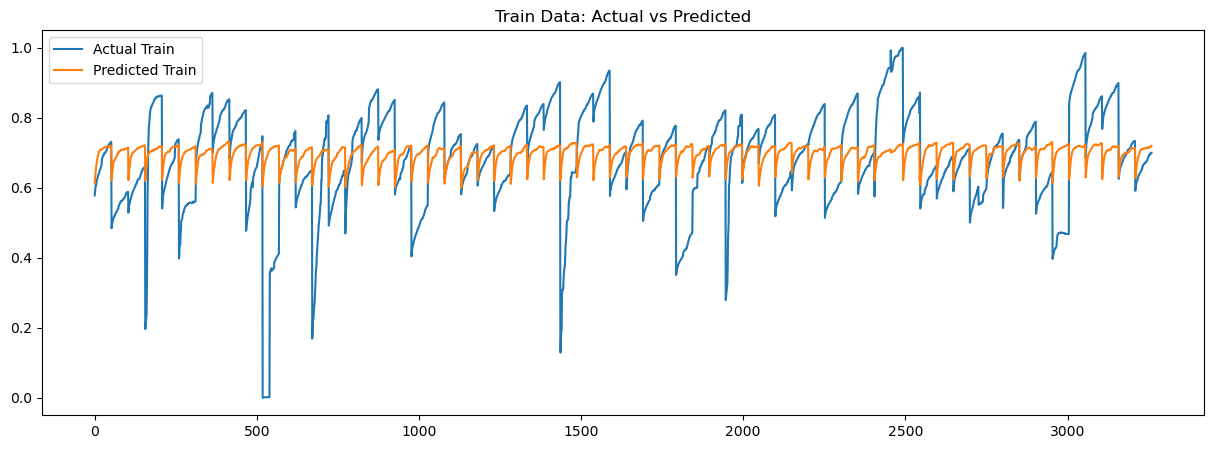

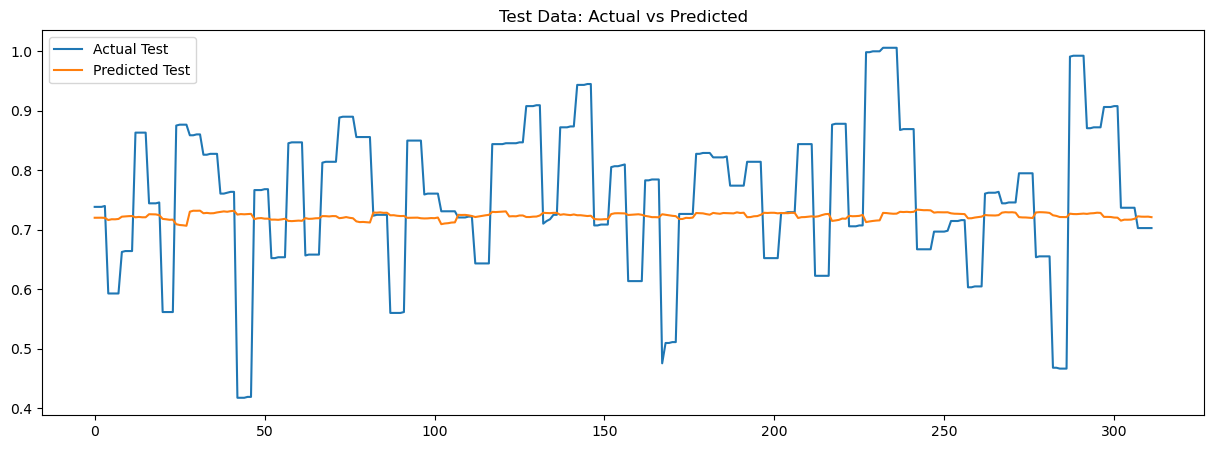

In [68]:
# Plotting train predictions and actual values
plt.figure(figsize=(15, 5))
plt.plot(range(len(y_train)), y_train, label='Actual Train')
plt.plot(range(len(train_pred)), train_pred, label='Predicted Train')
plt.title('Train Data: Actual vs Predicted')
plt.legend()
plt.show()

# Plotting test predictions and actual values
plt.figure(figsize=(15, 5))
plt.plot(range(len(y_test)), y_test, label='Actual Test')
plt.plot(range(len(test_pred)), test_pred, label='Predicted Test')
plt.title('Test Data: Actual vs Predicted')
plt.legend()
plt.show()

In [79]:
best_config

{'neurons': 32,
 'dropout': 0.2,
 'l1_reg': 1e-05,
 'l2_reg': 1e-05,
 'batch_size': 128,
 'filepath': './best_model_32_0.2_1e-05_1e-05_128.h5'}

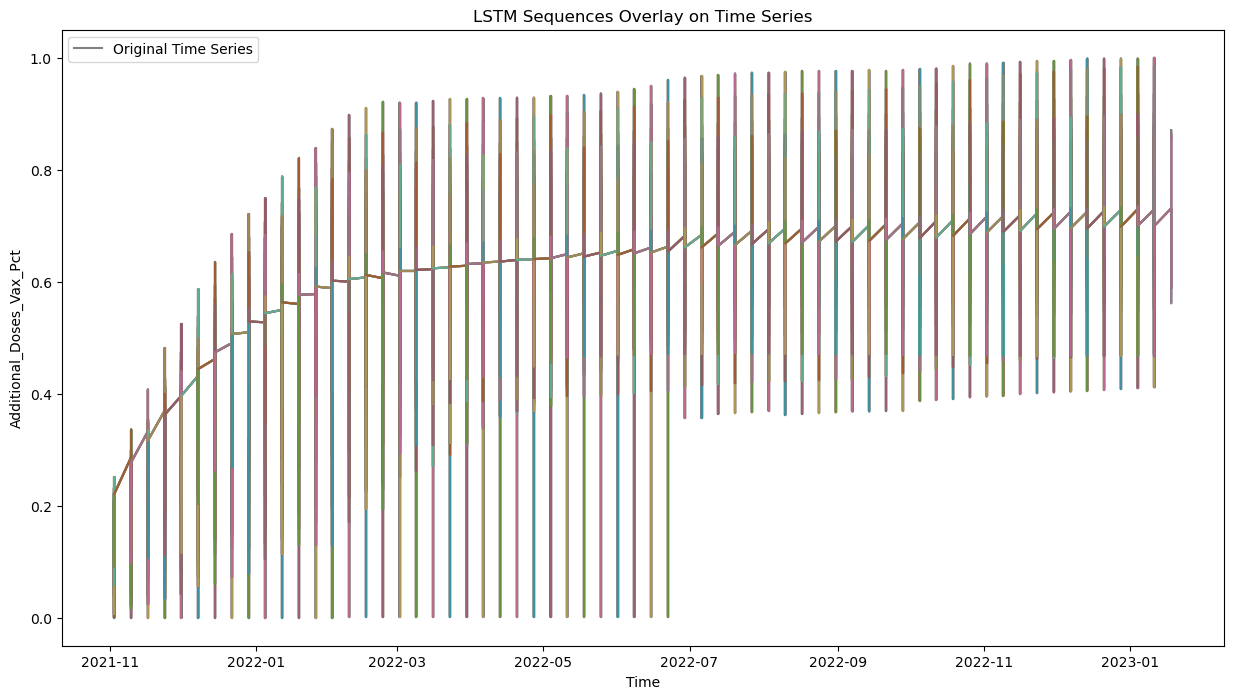

In [86]:
import matplotlib.pyplot as plt

# Reset the index of train_scaled to convert multi-index to columns
train_scaled_reset = train_scaled.reset_index()

# Plotting the original time series
plt.figure(figsize=(15, 8))
plt.plot(train_scaled_reset['Date'], train_scaled_reset[pred_var], label='Original Time Series', color='grey')

# Overlaying sequences
for i in range(sequence_length, len(train_scaled_reset)):
    sequence = train_scaled_reset.iloc[i-sequence_length:i]
    target = train_scaled_reset.iloc[i][pred_var]
    plt.plot(sequence['Date'], sequence[pred_var], alpha=0.5)


plt.xlabel('Time')
plt.ylabel(pred_var)
plt.title('LSTM Sequences Overlay on Time Series')
plt.legend()
plt.show()
